In [1]:
import numpy
#copied from the matlab by falsy winchnet.
#Emperical Fourier Decomposition technique

def segm_tec(f, N):
    locmax = numpy.zeros((f.size))
    for i in range(1, len(f) - 1):
        if ((f[i - 1] <= f[i]) and (f[i] > f[i + 1])):
            if (f[i] > 0):  # a value below 0 or 0 is not a maxima!
                locmax[i] = f[i]

    desc_sort_index = numpy.argsort(locmax)[::-1]
    desc_sort_bool = numpy.empty(desc_sort_index.shape[0], dtype=bool)
    for i in range(desc_sort_index.size):
        if locmax[i] > 0:
            desc_sort_bool[i] = True

    desc_sort_index = desc_sort_index[desc_sort_bool]

    if N != 0:  # keep the N-th highest maxima and their index
        if len(desc_sort_index) > N:
            desc_sort_index = desc_sort_index[0:N + 1]
        else:
            N = desc_sort_index.size
        desc_sort_index = numpy.sort(desc_sort_index)  # gotta sort them again
        bounds = numpy.empty(N+2, dtype=int)
        bounds[0] = 0
        bounds[1] = (numpy.argmin(f[0:desc_sort_index[0]]))  # -2
        for i in range(N - 2):
            bounds[i+2] = (desc_sort_index[i] + numpy.argmin(f[desc_sort_index[i]:desc_sort_index[i+1]]) - 1)
        bounds[-2] = (desc_sort_index[N] + numpy.argmin(f[desc_sort_index[N]:len(f)]) - 1)
        bounds[-1] = f.size
        cerf = desc_sort_index * numpy.pi / round(len(f))
    return numpy.asarray(bounds), cerf


#https://arxiv.org/pdf/2009.08047v2.pdf
def EFD(x: list[numpy.float64], N: int):
    #we will now implement the Empirical Fourier Decomposition
    x = numpy.asarray(x,dtype=numpy.float64)
    
    ff = numpy.fft.fft(x)
    #extract the boundaries of Fourier segments
    bounds,cerf = segm_tec(abs(ff[0:round(ff.size/2)]),N)
    # truncate the boundaries to [0,pi]
    bounds = bounds*numpy.pi/round(len(ff)/2)
    
    # extend the signal by miroring to deal with the boundaries
    l = round(len(x)/2)
    z = numpy.lib.pad(x,((round(len(x)/2)),round(len(x)/2)),'symmetric')
    
    ff = numpy.fft.fft(z)
    # obtain the boundaries in the extend f
    bound2 = numpy.ceil(bounds*round(len(ff)/2)/numpy.pi).astype(dtype=int)
    efd = numpy.zeros(((len(bound2)-1,len(x))),dtype=numpy.float64)
    ft = numpy.zeros((efd.shape[0],len(ff)),dtype=numpy.cdouble)
    # define an ideal functions and extract components
    for k in range(efd.shape[0]): 
        if bound2[k] == 0:
            ft[k,0:bound2[k+1]] = ff[0:bound2[k+1]]
            #ft[k,len(ff)+1-bound2[k+1]:len(ff)] = ff[len(ff)+1-bound2[k+1]:len(ff)]
            ft[k,-bound2[k+1]:len(ff)] = ff[-bound2[k+1]:len(ff)]

        else:
            ft[k,bound2[k]:bound2[k+1]] = ff[bound2[k]:bound2[k+1]]
            #ft[k,len(ff)+1-bound2[k+1]:len(ff)+1-bound2[k]] = ff[len(ff)+1-bound2[k+1]:len(ff)+1-bound2[k]]

            ft[k,-bound2[k+1]:-bound2[k]] = ff[-bound2[k+1]:-bound2[k]]
        rx =  numpy.real(numpy.fft.ifft(ft[k,:]))
        efd[k,:] = rx[l:-l]


    return efd,cerf,bounds

In [336]:
import numpy
import numba
import numpy as np
import scipy.interpolate as interpolate
import math

"""
MEITD is a non-parametric trend extraction reduction technique based on 
Intrinsic Time-Scale Decomposition, the use of this method for non-research purposes
may be restricted by law due to patent rights on the original ITD algorithm. 
MEITD, Maximal Extraction ensemble Intrinsic-Time-Scale Decomposition
iteratively selects and extracts proper rotations meeting Weighed Permutation Entropy
and seeks to extract a maximum number of components, to leave noise in a residual trend.
The implementation itself is released under the MIT and FSF licenses.

Copyright (C) 2007 Free Software Foundation, Inc. <https://fsf.org/>
Everyone is permitted to copy and distribute verbatim copies
of this license document, but changing it is not allowed.
"""


# I present Maximal Extraction Intrinsic Time-Scale Decomposition.
# This model is intended to perform maximum extractions, and then sort
# the output by entropy. Noise is generally the very last item-
# the trends from 0:-1 are increasing entropy and frequency.


# The following functions are implemented/stolen here:
# numba accelerated cubic interpolation(except the spline construction, splrep, not sure about time cost there
# two different findpeaks functions: not sure which to use
# the matlab style version will always provide rotations which meet frei-osorio "proper rotation" criteria.
# however, these rotations are often not orthonormal and the non-"proper rotation" findpeaks will return
# rotations with extrema translated below and above 0, but which better fit the data.
# I am going to personally go with the second findpeak, but if you are interested in statistically correct answers,
# just switch it out for matlab_detect_peaks

# ensemble ITD "        Hu, Aijun; Yan, Xiaoan; Xiang, Ling  (2015).
# A new wind turbine fault diagnosis method based on ensemble intrinsic time-scale decomposition
# and WPT-fractal dimension. Renewable Energy, 83(), 767–778.
# doi:10.1016/j.renene.2015.04.063 
# is partially implemented here.
# EITD-MP "Wang, Xiaoling; Ling, Bingo Wing-Kuen (2019).
# Underlying Trend Extraction via Joint Ensemble Intrinsic Timescale Decomposition Algorithm and Matching Pursuit Approach.
# Circuits, Systems, and Signal Processing, (), –. doi:10.1007/s00034-019-01069-2
# https://sci-hub.hkvisa.net/10.1016/j.renene.2015.04.063#
# https://sci-hub.hkvisa.net/10.1007/s00034-019-01069-2
#

@numba.jit(cache=True)
def _embed(x, order=3, delay=1):
    """Time-delay embedding.
    Parameters
    ----------
    x : 1d-array, shape (n_times)
        Time series
    order : int
        Embedding dimension (order)
    delay : int
        Delay.
    Returns
    -------
    embedded : ndarray, shape (n_times - (order - 1) * delay, order)
        Embedded time-series.
    """
    N = len(x)
    Y = np.empty((order, N - (order - 1) * delay))
    for i in range(order):
        Y[i] = x[i * delay:i * delay + Y.shape[1]]
    return Y.T

def util_rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def weighted_permutation_entropy(time_series, order=3, normalize=False):
    """Calculate the Weighted Permutation Entropy.
    Weighted permutation entropy is based on the regular permutation entropy,
    but puts additional weight on those windows that show a high variability
    in the initial time series.
    Parameters
    ----------
    time_series : list or np.array
        Time series
    order : int
        Order of permutation entropy
    normalize : bool
        If True, divide by log2(factorial(m)) to normalize the entropy
        between 0 and 1. Otherwise, return the permutation entropy in bit.
    Returns
    -------
    pe : float
        Weighted Permutation Entropy
    References
    ----------
    .. [1] Bilal Fadlallah et al. Weighted-permutation entropy: A complexity
    measure for time series incorporating amplitude information
    https://link.aps.org/accepted/10.1103/PhysRevE.87.022911
    """
    x = np.array(time_series)
    hashmult = np.power(order, np.arange(order))
    # Embed x and sort the order of permutations

    embedded = _embed(x, order=order)
    sorted_idx = embedded.argsort(kind='quicksort')
    weights = np.var(util_rolling_window(x, order), 1)
    hashval = (np.multiply(sorted_idx, hashmult)).sum(1)
    mapping = {}
    for i in np.unique(hashval):
        mapping[i] = np.where(hashval == i)[0]
    weighted_counts = dict.fromkeys(mapping)
    for k, v in mapping.items():
        weighted_count = 0
        for i in v:
            weighted_count += weights[i]
        weighted_counts[k] = weighted_count
    # Associate unique integer to each permutations
    # Return the counts
    # Use np.true_divide for Python 2 compatibility
    weighted_counts_array = np.array(list(weighted_counts.values()))
    p = np.true_divide(weighted_counts_array, weighted_counts_array.sum())
    pe = -np.multiply(p, np.log2(p)).sum()
    if normalize:
        pe /= np.log2(math.factorial(order))
    return pe


def custom_splrep(x, y, k=3):
    """
    Custom wrap of scipy's splrep for calculating spline coefficients,
    which also check if the data is equispaced.

    """

    # Check if x is equispaced
    x_diff = np.diff(x)
    equi_spaced = all(np.round(x_diff, 5) == np.round(x_diff[0], 5))
    dx = x_diff[0]

    # Calculate knots & coefficients (cubic spline by default)
    t, c, k = interpolate.splrep(x, y, k=k)

    return (t, c, k, equi_spaced, dx)


@numba.njit(cache=True)
def numba_splev(x, coeff):
    """
    Custom implementation of scipy's splev for spline interpolation,
    with additional section for faster search of knot interval, if knots are equispaced.
    Spline is extrapolated from the end spans for points not in the support.

    """
    t, c, k, equi_spaced, dx = coeff

    t0 = t[0]

    n = t.size
    m = x.size

    k1 = k + 1
    k2 = k1 + 1
    nk1 = n - k1

    l = k1
    l1 = l + 1

    y = np.zeros(m)

    h = np.zeros(20)
    hh = np.zeros(19)

    for i in range(m):

        # fetch a new x-value arg
        arg = x[i]

        # search for knot interval t[l] <= arg <= t[l+1]
        if (equi_spaced):
            l = int((arg - t0) / dx) + k
            l = min(max(l, k1), nk1)
        else:
            while not ((arg >= t[l - 1]) or (l1 == k2)):
                l1 = l
                l = l - 1
            while not ((arg < t[l1 - 1]) or (l == nk1)):
                l = l1
                l1 = l + 1

        # evaluate the non-zero b-splines at arg.
        h[:] = 0.0
        hh[:] = 0.0

        h[0] = 1.0

        for j in range(k):

            for ll in range(j + 1):
                hh[ll] = h[ll]
            h[0] = 0.0

            for ll in range(j + 1):
                li = l + ll
                lj = li - j - 1
                if (t[li] != t[lj]):
                    f = hh[ll] / (t[li] - t[lj])
                    h[ll] += f * (t[li] - arg)
                    h[ll + 1] = f * (arg - t[lj])
                else:
                    h[ll + 1] = 0.0
                    break

        sp = 0.0
        ll = l - 1 - k1

        for j in range(k1):
            ll += 1
            sp += c[ll] * h[j]
        y[i] = sp

    return y


@numba.njit(numba.boolean[:](numba.int64[:], numba.int64[:]), parallel=True)
def isin(a, b):
    out = numpy.empty(a.shape[0], dtype=numba.boolean)
    b = set(b)
    for i in numba.prange(a.shape[0]):
        if a[i] in b:
            out[i] = True
        else:
            out[i] = False
    return out


@numba.njit(numba.int64[:](numba.float64[:]),cache=True)
def matlab_detect_peaks(x: list[float]):
    """Detect peaks in data based on their amplitude and other features.
    warning: this code is an optimized copy of the "Marcos Duarte, https://github.com/demotu/BMC"
    matlab compliant detect peaks function intended for use with data sets that only want
    rising edge and is optimized for numba. experiment with it at your own peril.
    """
    # find indexes of all peaks
    x = numpy.asarray(x)
    if len(x) < 3:
        return numpy.empty(1, numpy.int64)
    dx = x[1:] - x[:-1]
    dx = -dx
    # handle NaN's
    indnan = numpy.where(numpy.isnan(x))[0]
    indl = numpy.asarray(indnan)

    if indl.size != 0:
        x[indnan] = numpy.inf
        dx[numpy.where(numpy.isnan(dx))[0]] = numpy.inf

    vil = numpy.zeros(dx.size + 1)
    vil[:-1] = dx[:]  # hacky solution because numba does not like hstack tuple arrays
    # numpy.asarray((dx[:], [0.]))# hacky solution because numba does not like hstack
    vix = numpy.zeros(dx.size + 1)
    vix[1:] = dx[:]

    ind = numpy.unique(numpy.where((vil > 0) & (vix <= 0))[0])

    # handle NaN's
    # NaN's and values close to NaN's cannot be peaks
    if ind.size and indl.size:
        outliers = numpy.unique(numpy.concatenate((indnan, indnan - 1, indnan + 1)))
        booloutliers = isin(ind, outliers)
        booloutliers = numpy.invert(booloutliers)
        ind = ind[booloutliers]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size - 1:
        ind = ind[:-1]

    # eliminate redundant values
    return ind


@numba.jit(cache=True)
def baseline_knot_estimation(baseline_knots: list[numpy.float64], x: list[numpy.float64],
                             extrema_indices: list[numpy.float64]):
    alpha = 0.5
    for k in range(1, len(extrema_indices) - 1):
        baseline_knots[k] = alpha * (x[extrema_indices[k - 1]] \
                                     + ((extrema_indices[k] - extrema_indices[k - 1]) \
                                        / (extrema_indices[k + 1] - extrema_indices[k - 1])) \
                                     * (x[extrema_indices[k + 1]] - x[extrema_indices[k - 1]])) \
                            + (alpha * x[extrema_indices[k]])

    return baseline_knots


def itd_baseline_extract(data: list[numpy.float64]) -> [numpy.ndarray, numpy.ndarray]:
    x = numpy.asarray(data, dtype=numpy.float64)
    rotation = numpy.zeros_like(x)
    baseline_new = numpy.zeros_like(x)

    idx_max = numpy.asarray(matlab_detect_peaks(x))
    idx_min = numpy.asarray(matlab_detect_peaks(-x))

    num_extrema = idx_min.size + idx_max.size
    extremabuffersize = num_extrema + 2
    extrema_indices = numpy.zeros(extremabuffersize, dtype=numpy.int64)
    extrema_indices[1:-1] = numpy.sort(numpy.unique(numpy.hstack((idx_max, idx_min))))
    extrema_indices[-1] = len(x) - 1

    baseline_knots = numpy.zeros(len(extrema_indices))

    padded = numpy.pad(x, 1, mode='reflect', reflect_type="odd")
    baseline_knots[0] = numpy.mean(padded[:2])
    baseline_knots[-1] = numpy.mean(padded[-2:])

    baseline_knots[:] = baseline_knot_estimation(baseline_knots[:], x[:], extrema_indices[:])

    z = numpy.zeros_like(x)
    z[:] = range(z.shape[0])
    coeff = custom_splrep(extrema_indices, baseline_knots)
    baseline_new[:] = numba_splev(z, coeff)

    rotation[:] = numpy.subtract(x, baseline_new)

    return rotation[:], baseline_new[:]


def itd(data: numpy.ndarray) -> numpy.ndarray:
    rotations = numpy.zeros((100, len(data)), dtype=numpy.float64)
    baselines = numpy.zeros((100, len(data)), dtype=numpy.float64)
    rotation_ = numpy.zeros((len(data)), dtype=numpy.float64)
    baseline_ = numpy.zeros((len(data)), dtype=numpy.float64)
    rotation_[:], baseline_[:] = itd_baseline_extract((numpy.asarray(data, dtype=numpy.float64)))
    counter = 0
    while 1:
        idx_max = numpy.asarray(matlab_detect_peaks(baseline_))
        idx_min = numpy.asarray(matlab_detect_peaks(-baseline_))
        num_extrema = len(idx_min) + len(idx_max)
        if num_extrema < 5:
            # is the new baseline decomposable?
            print("No more decompositions possible")
            # implied: last decomposition was invalid!
            # not always the case, but efforts to decompose the trend which are meaningful
            # require a little adjustment to get the baseline monotonic trend to show properly.
            rotations[counter, :] = baseline_copy
            counter = counter + 1
            return rotations[0:counter, :]

        elif counter > 98:
            print("Out of time!")
            rotations[counter, :] = baseline_copy
            counter = counter + 1
            return rotations[0:counter, :]

        else:  # results are sane, so perform an extraction.
            rotations[counter, :] = rotation_.copy()
            baselines[counter, :] = baseline_.copy()
            baseline_copy = baseline_.copy()
            rotation_, baseline_ = itd_baseline_extract(baseline_)
            counter = counter + 1


def retrieve_descending_pair_rotation_with_added_noise(r1=numpy.ndarray, r2=numpy.ndarray):
    # in this function, we will assume that the input vector is a proper rotation(or a baseline!)
    # that the operator wishes to treat as a baseline and decompose in the manner of
    # ensemble ITD- where the normal ITD cycling process is called until termination or success
    # to which noise has already been added

    r1 = numpy.asarray(r1).astype(dtype=numpy.float64)
    r2 = numpy.asarray(r2).astype(dtype=numpy.float64)
    r3 = (r1 + r2 ) /2
    idx_max = numpy.asarray(matlab_detect_peaks(r3))
    idx_min = numpy.asarray(matlab_detect_peaks(r3))
    num_extrema = idx_min.size + idx_max.size
    if num_extrema < 5:
        print("what are you feeding me??")
        return r3, 0

    rotation_1, baseline_1 = itd_baseline_extract(r1[:])
    rotation_2, baseline_2 = itd_baseline_extract(r2[:])
    PRC = (rotation_1 + rotation_2) / 2
    WPE = weighted_permutation_entropy(PRC, order=3, normalize=True)
    WPESUM = numpy.mean(WPE)
    idx_max = numpy.asarray(matlab_detect_peaks(PRC))
    idx_min = numpy.asarray(matlab_detect_peaks(PRC))
    num_extrema = idx_min.size + idx_max.size
    while (WPESUM > 0.6):
        # while we havn't returned a proper rotation yet

        rotation_1[:], baseline_1[:] = itd_baseline_extract(baseline_1[:])
        rotation_2[:], baseline_2[:] = itd_baseline_extract(baseline_2[:])
        PRC = (rotation_1 + rotation_2) / 2
        WPE = weighted_permutation_entropy(PRC, order=3, normalize=True)
        WPESUM = numpy.mean(WPE)
        idx_max = numpy.asarray(matlab_detect_peaks(PRC))
        idx_min = numpy.asarray(matlab_detect_peaks(PRC))
        num_extrema = idx_min.size + idx_max.size
        if num_extrema <= 5:
            print("failed to decompose paired descending rotation")
            return r3, 0
        if WPESUM < 0.2:
            return r3, 0 #this isn't a good idea
        return PRC, 1  # the only way the logic gets to here is if we had a qualified decomposition, right?
    return r3,0


# Process 1
def retrieve_initial_pair_rotation_with_added_noise(x=numpy.ndarray):
    x = numpy.asarray(x).astype(dtype=numpy.float64)

    idx_max = numpy.asarray(matlab_detect_peaks(x))
    idx_min = numpy.asarray(matlab_detect_peaks(-x))
    num_extrema = idx_min.size + idx_max.size
    if num_extrema < 5:
        print("what are you feeding me??")
        return x, 0
    yz = numpy.std(x)
    noise = np.random.normal(0, numpy.std(x), x.shape)
    noise_inverted = noise * -1
    p1 = x + noise
    p2 = x + noise_inverted

    rotation_1, baseline_1 = itd_baseline_extract(p1[:])
    rotation_2, baseline_2 = itd_baseline_extract(p2[:])
    PRC = (rotation_1 + rotation_2) / 2
    WPE = weighted_permutation_entropy(PRC, order=3, normalize=True)
    WPESUM = numpy.mean(WPE)
    if WPESUM < 0.6:  # criteria?
        if WPESUM < 0.2:
            return x, 0 #this isn't a good idea either
        return PRC, 1
    return x, 0

    # equation 1


def MMEITD(data: numpy.ndarray, max_iteration: int = 40) -> numpy.ndarray:
    x = data
    highrotations = numpy.zeros((100, len(data)), dtype=numpy.float64)
    lowrotations = numpy.zeros((100, len(data)), dtype=numpy.float64)
    middlerotations = numpy.zeros((100, len(data)), dtype=numpy.float64)
    highcounter = 0
    lowcounter = 0
    middlecounter = 0
    zero_sum = numpy.zeros((len(data)), dtype=numpy.float64)
    idx_max = numpy.asarray(matlab_detect_peaks(x))
    idx_min = numpy.asarray(matlab_detect_peaks(-x))
    num_extrema = idx_max.size + idx_min.size
    if num_extrema <= 5:  # initial QC check
        print("what are you feeding the main function!?")
        return zero_sum, zero_sum, zero_sum, x

    # if the WPE factor for the first rotations are not suitable, the product is discarded,
    # and the first rotation of t is extracted, and then t(r)1 is taken as t and the process
    # of seeking a suitable first rotation using noise is repeated(run process 1 on t(r)1)
    # If this succeeds, extract the rotation. any output products of this by process 1 are placed into a
    # table marked HF. Whether this process succeeds or fails, run process 3.

    trigger = 1
    while num_extrema > 5 and trigger == 1:
        if highcounter > 98:
            break
        if lowcounter > 98:
            break
        if middlecounter > 98:
            break
        trigger = 0
        rotation_, proper_rotation = retrieve_initial_pair_rotation_with_added_noise(x)
        if proper_rotation:
            middlerotations[middlecounter, :] = rotation_
            middlecounter = middlecounter + 1
            x = x - rotation_  # remove the decomposed product
            trigger = 1
        else:
            rotation_, baseline_ = itd_baseline_extract(x)
            yz = numpy.std(rotation_)
            noise = np.random.normal(0, numpy.std(rotation_), x.shape)
            noise_inverted = noise * -1
            p1 = rotation_ + noise
            p2 = rotation_ + noise_inverted
            PRC, proper_rotation = retrieve_descending_pair_rotation_with_added_noise(p1, p2)
            if proper_rotation:
                highrotations[highcounter, :] = PRC
                highcounter = highcounter + 1
                x = x - PRC  # remove the decomposed product
                trigger = 1

        yz = numpy.std(x)
        noise = np.random.normal(0, yz, x.shape)
        noise_inverted = noise * -1
        p1 = x + noise
        p2 = x + noise_inverted
        PRC, proper_rotation = retrieve_descending_pair_rotation_with_added_noise(p1, p2)
        #for baseline decompositions, we just attempt to retrieve lower baseline decomposables
        if proper_rotation:
            lowrotations[lowcounter, :] = PRC
            lowcounter = lowcounter + 1
            x = x - PRC
            trigger = 1
        
        else:
            #ok, so we failed to iterate down ITD to the trend to find a baseline.
            #let's try this one more time in this round using the first rotation of X past
            #the baseline as our invisible baseline.
            rotation_, baseline_ = itd_baseline_extract(x)
            rotation_, baseline_ = itd_baseline_extract(baseline_)
            idx_max = numpy.asarray(matlab_detect_peaks(baseline_))
            idx_min = numpy.asarray(matlab_detect_peaks(-baseline_))
            num_extrema = idx_max.size + idx_min.size 
            #somewhat obviously, if we don't have enough extrema, don't bother trying!
            while num_extrema > 5:
                noise = np.random.normal(0,numpy.std(rotation_), x.shape)
                noise_inverted = noise * -1
                p1 = rotation_ + noise
                p2 = rotation_ + noise_inverted
                PRC, proper_rotation = retrieve_descending_pair_rotation_with_added_noise(p1, p2)
                if proper_rotation:
                    lowrotations[lowcounter, :] = PRC
                    lowcounter = lowcounter + 1
                    x = x - PRC
                    trigger = 1
                    break #terminate this while loop
                rotation_, baseline_ = itd_baseline_extract(baseline_) #otherwise
                idx_max = numpy.asarray(matlab_detect_peaks(baseline_))
                idx_min = numpy.asarray(matlab_detect_peaks(-baseline_))
                num_extrema = idx_max.size + idx_min.size
            #this codepath increases the recomposition error considerably
        idx_max = numpy.asarray(matlab_detect_peaks(x))
        idx_min = numpy.asarray(matlab_detect_peaks(-x))
        num_extrema = idx_max.size + idx_min.size
        # at this point. We've decomposed everything we think is a proper rotational component.
        # however, the number of extrema may still be more than 6.
        # the suggestion here is that we have more to decompose.
    if highcounter > 0 and lowcounter > 0 and middlecounter > 0:
        return highrotations[0:highcounter, :], middlerotations[0:middlecounter, :], lowrotations[0:lowcounter, :], x
    elif highcounter > 0 and middlecounter > 0:
        return highrotations[0:highcounter, :], middlerotations[0:middlecounter, :], zero_sum, x
    elif highcounter > 0 and lowcounter > 0:
        return highrotations[0:highcounter, :], zero_sum, lowrotations[0:lowcounter, :], x
    elif middlecounter > 0 and lowcounter > 0:
        return zero_sum, middlerotations[0:middlecounter, :], lowrotations[0:lowcounter, :], x
    elif highcounter > 0:
        return highrotations[0:highcounter, :], zero_sum, zero_sum, x
    elif middlecounter > 0:
        return zero_sum, middlerotations[0:middlecounter, :], zero_sum, x
    elif lowcounter > 0:
        return zero_sum, zero_sum, lowrotations[0:lowcounter, :], x

def MDMEITD(data: numpy.ndarray):
    data = numpy.asarray(data, dtype=numpy.float64)
    #m_ = data.mean(axis=0)
    #sd_ = data.std(axis=0, ddof=0)
    #WPEMAX = numpy.log(abs(20 * numpy.log10(abs(numpy.where(sd_ == 0, 0, m_ / sd_)))))
    # accurately estimate the maximum good rotations
    efdhigh = numpy.zeros((100, len(data)), dtype=numpy.float64)
    efdlow = numpy.zeros((100, len(data)), dtype=numpy.float64)
    efdmiddle = numpy.zeros((100, len(data)), dtype=numpy.float64)
    efdlowcount = 0
    efdmiddlecount = 0
    efdhighcount = 0

    highrotations, middlerotations, lowrotations, residual = MMEITD(data)
    counter = 3
    while counter > 0:
        if efdlowcount > 98:
            break
        if efdmiddlecount > 98:
            break
        if efdhighcount > 98:
            break
        counter = 3
        if not numpy.all((highrotations == 0)):
            efd, cerf, bounds = EFD(highrotations[0, :], 1)
            data = data - efd[1, :] 
            efdhigh[efdhighcount, :] = efd[1, :]
            efdhighcount = efdhighcount + 1
        if not numpy.all((middlerotations == 0)):
            efd, cerf, bounds = EFD(middlerotations[0, :], 1)
            data = data - efd[1, :]  
            efdmiddle[efdmiddlecount, :] = efd[1, :]
            efdmiddlecount = efdmiddlecount +1
        if not numpy.all((lowrotations == 0)):
            efd, cerf, bounds = EFD(lowrotations[0, :], 1)
            data = data - efd[1, :] 
            efdlow[efdlowcount, :] = efd[1, :]
            efdlowcount = efdlowcount + 1
        highrotations, middlerotations, lowrotations, residual = MMEITD(data)
        if numpy.all(highrotations == 0):
            counter = counter - 1
        if numpy.all(middlerotations == 0):
            counter = counter - 1
        if numpy.all(lowrotations == 0):
            counter = counter - 1
    #rotations = itd(data)
    #efd_ ,bounds, cerf = EFD(rotations[0], 1)
    #data = data - efd_[-1, :]
    efdhighx = numpy.zeros_like(data)
    results = numpy.vstack((efdhigh[0:efdhighcount,:], efdmiddle[0:efdmiddlecount,:]))
    results = numpy.vstack((results, efdlow[0:efdlowcount,:]))
    noise = np.random.normal(0, numpy.std(data), data.shape)
    noise_inverted = noise * -1
    p1 = data + noise
    p2 = data + noise_inverted                 
    x1 = itd(p1)                       
    x2 = itd(p2)
    rotations = numpy.amin([x1.shape[0],x2.shape[0]])
    rarray = numpy.zeros((30, len(data)), dtype=numpy.float64)
    xhoolder = numpy.zeros_like(data)
    for each in range(rotations-1):
        rarray[each,:] = (x1[each,:] + x2[each,:]) /2
    resdel = numpy.zeros_like(data)
    for i in range(rarray.shape[0]):
        resdel[i] = math.fsum(rarray[:,i])
    residual = data - resdel                     
    results = numpy.vstack((results, rarray[0:rotations]))
    results = numpy.vstack((results, residual))
    #results = numpy.vstack((results, efd_[-1, :]))
    return results #this returns a set of trends and a single array of all the proper frequency components as one


In [340]:
import numpy
arp256clean = [1.400699999999999689e-22, 1.821100000000000012e-22, 2.159400000000000123e-22, 2.644499999999999981e-22, 3.291099999999999715e-22, 5.027400000000000143e-22, 7.117699999999999467e-22, 9.491600000000000001e-22, 2.974000000000000146e-21, 3.920499999999999489e-21, 4.429299999999999341e-21, 4.746100000000001336e-21, 5.589099999999999770e-21, 6.446699999999999129e-21, 7.150599999999998916e-21, 9.127199999999996874e-21, 1.060100000000000063e-20, 2.090900000000000151e-20, 4.021100000000000288e-20, 4.746100000000000884e-20, 5.627800000000000640e-20, 6.657899999999999255e-20, 7.504800000000000118e-20, 8.817399999999999686e-20, 1.017000000000000178e-19, 1.133300000000000212e-19, 1.298200000000000101e-19, 1.430000000000000046e-19, 1.528800000000000100e-19, 1.731200000000000031e-19, 2.010700000000000161e-19, 2.199600000000000125e-19, 2.456599999999999990e-19, 2.743700000000000180e-19, 2.967200000000000378e-19, 3.253400000000000345e-19, 3.893500000000000217e-19, 4.279000000000000015e-19, 4.542999999999999631e-19, 4.992800000000000504e-19, 7.750700000000000289e-19, 1.337599999999999916e-18, 1.743200000000000092e-18, 1.775600000000000012e-18, 1.964899999999999845e-18, 1.735199999999999826e-18, 2.052799999999999970e-18, 2.209699999999999882e-18, 2.297899999999999921e-18, 2.378699999999999908e-18, 2.462299999999999987e-18, 2.548799999999999873e-18, 2.537100000000000159e-18, 2.681300000000000131e-18, 2.699900000000000171e-18, 2.846700000000000037e-18, 3.057299999999999902e-18, 3.194000000000000107e-18, 3.306299999999999887e-18, 3.406700000000000138e-18, 3.502199999999999746e-18, 3.608600000000000196e-18, 3.684200000000000010e-18, 3.650400000000000236e-18, 3.822399999999999783e-18, 3.902499999999999842e-18, 3.947700000000000187e-18, 3.965899999999999828e-18, 3.984199999999999954e-18, 4.048900000000000080e-18, 4.067599999999999834e-18, 4.076999999999999953e-18, 4.105300000000000026e-18, 4.143199999999999647e-18, 4.143199999999999647e-18, 4.210599999999999766e-18, 4.757100000000001442e-18, 8.420500000000000762e-18, 8.696399999999999424e-18, 9.064400000000000856e-18, 8.858100000000000652e-18, 1.138500000000000066e-17, 1.316299999999999844e-17, 1.470099999999999904e-17, 1.426699999999999966e-17, 1.715300000000000418e-17, 1.787900000000000170e-17, 2.071800000000000023e-17, 2.373199999999999975e-17, 2.572399999999999963e-17, 2.638400000000000074e-17, 2.994599999999999766e-17, 3.201400000000000237e-17, 3.414600000000000304e-17, 3.510300000000000804e-17, 3.534600000000000282e-17, 4.449799999999999850e-17, 4.328499999999999732e-17, 5.180099999999999731e-17, 5.436799999999999913e-17, 5.679899999999998874e-17, 6.417099999999999543e-17, 6.860200000000000521e-17, 7.333999999999999956e-17, 8.004599999999999454e-17, 8.676399999999999839e-17, 9.106299999999997220e-17, 9.557400000000000004e-17, 9.961899999999999971e-17, 1.094800000000000060e-16, 9.491600000000000247e-17, 1.170399999999999997e-16, 1.219900000000000111e-16, 1.313200000000000069e-16, 1.413599999999999935e-16, 1.535799999999999978e-16, 1.623099999999999938e-16, 1.649499999999999982e-16, 2.566499999999999894e-16, 1.796099999999999741e-15, 4.095800000000000014e-15, 8.228899999999999273e-15, 1.162399999999999956e-14, 1.381500000000000065e-14, 2.513900000000000085e-15, 1.307199999999999942e-14, 1.319299999999999803e-14, 1.783799999999999995e-14, 1.672399999999999960e-14, 6.766100000000000826e-15, 1.228400000000000003e-14, 2.219899999999999962e-14, 2.174399999999999992e-14, 1.792000000000000089e-14, 2.090899999999999956e-14, 1.715300000000000085e-14, 2.174399999999999992e-14, 2.048000000000000147e-14, 1.987600000000000033e-14, 1.787899999999999884e-14, 2.189500000000000099e-14, 2.001400000000000060e-14, 2.100600000000000094e-14, 2.164399999999999908e-14, 1.557199999999999981e-14, 2.124900000000000114e-14, 1.608199999999999903e-14, 1.183999999999999991e-14, 6.876099999999999852e-15, 1.490500000000000061e-14, 2.115099999999999994e-14, 2.261200000000000061e-14, 2.174400000000000307e-14, 1.955900000000000090e-14, 2.319199999999999978e-14, 2.367800000000000018e-14, 1.942400000000000008e-14, 1.969399999999999855e-14, 2.324599999999999947e-14, 2.209699999999999914e-14, 2.010699999999999955e-14, 2.271600000000000072e-14, 2.219899999999999962e-14, 2.033899999999999858e-14, 2.081300000000000116e-14, 2.100600000000000094e-14, 1.804400000000000054e-14, 1.889500000000000115e-14, 1.964900000000000039e-14, 1.978500000000000102e-14, 1.992200000000000147e-14, 2.062200000000000417e-14, 2.062200000000000101e-14, 2.015300000000000069e-14, 1.889500000000000115e-14, 1.889500000000000115e-14, 1.889500000000000115e-14, 1.898200000000000118e-14, 1.792000000000000404e-14, 1.619299999999999787e-14, 1.703500000000000011e-14, 1.699600000000000086e-14, 1.504300000000000403e-14, 1.575199999999999879e-14, 1.507800000000000086e-14, 1.560799999999999961e-14, 1.645699999999999427e-14, 1.684000000000000069e-14, 1.707399999999999937e-14, 1.680100000000000144e-14, 1.680100000000000144e-14, 1.619300000000000103e-14, 1.699600000000000086e-14, 1.703500000000000011e-14, 1.619299999999999787e-14, 1.723199999999999917e-14, 1.615600000000000141e-14, 1.727200000000000140e-14, 1.755300000000000104e-14, 1.672399999999999960e-14, 1.611899999999999864e-14, 1.535800000000000383e-14, 1.525200000000000092e-14, 1.600799999999999980e-14, 1.557199999999999981e-14, 1.626800000000000008e-14, 1.528800000000000072e-14, 1.535799999999999752e-14, 1.557199999999999981e-14, 1.619300000000000103e-14, 1.619300000000000103e-14, 1.494000000000000059e-14, 1.535800000000000067e-14, 1.483700000000000029e-14, 1.375099999999999961e-14, 1.362500000000000032e-14, 1.397500000000000167e-14, 1.490500000000000061e-14, 1.365699999999999926e-14, 1.295200000000000062e-14, 1.387800000000000029e-14, 1.322300000000000049e-14, 1.289300000000000026e-14, 1.343799999999999945e-14, 1.384599999999999977e-14, 1.286299999999999938e-14, 1.387800000000000029e-14, 1.429999999999999965e-14, 1.349999999999999770e-14, 1.316300000000000031e-14, 1.353099999999999998e-14, 1.322300000000000049e-14, 1.378300000000000013e-14, 1.292199999999999974e-14, 1.322300000000000049e-14, 1.271600000000000073e-14, 1.289300000000000184e-14, 1.356300000000000050e-14, 1.274500000000000022e-14, 1.322300000000000049e-14, 1.254099999999999927e-14, 1.280400000000000059e-14, 1.286299999999999938e-14, 1.301199999999999923e-14, 1.248400000000000012e-14, 1.236900000000000042e-14, 1.277399999999999970e-14, 1.251199999999999979e-14, 1.239799999999999991e-14, 1.217099999999999996e-14, 1.254099999999999927e-14, 1.225600000000000036e-14, 1.189399999999999960e-14, 1.154399999999999983e-14, 1.197700000000000036e-14, 1.170800000000000171e-14, 1.134100000000000186e-14, 1.153100000000000061e-14, 1.164299999999999927e-14, 1.178400000000000058e-14, 1.125599999999999989e-14, 1.131300000000000062e-14, 1.093399999999999978e-14, 9.120099999999999239e-15, 1.040399999999999945e-14, 1.021899999999999980e-14, 1.060800000000000040e-14, 1.013499999999999922e-14, 1.025499999999999960e-14, 9.820999999999999249e-15, 1.017100000000000060e-14, 9.853299999999999399e-15, 9.949400000000001888e-15, 1.020700000000000039e-14, 9.865500000000000662e-15, 1.019399999999999959e-14, 1.008199999999999935e-14, 9.971800000000000043e-15, 9.724800000000000565e-15, 9.887900000000000395e-15, 9.339499999999999609e-15, 1.000999999999999976e-14, 9.346700000000000200e-15, 9.610999999999999386e-15, 9.287100000000000572e-15, 9.291899999999997810e-15, 9.145700000000000286e-15, 9.515699999999999593e-15, 9.346900000000000479e-15, 9.633400000000000697e-15, 9.572099999999999484e-15, 9.489399999999999935e-15, 9.233200000000000229e-15, 9.153400000000000786e-15, 9.285700000000001772e-15, 9.417299999999999414e-15, 9.821100000000000177e-15, 9.894500000000000147e-15, 9.365100000000000656e-15, 9.566299999999997694e-15, 9.549499999999999472e-15, 9.227800000000000575e-15, 9.318299999999999975e-15, 9.046000000000000658e-15, 8.968000000000000574e-15, 9.203099999999999996e-15, 8.512400000000001611e-15, 8.596000000000001629e-15, 8.758199999999999413e-15, 8.967199999999999456e-15, 8.707700000000002241e-15, 7.780800000000000531e-15, 8.095999999999999026e-15, 8.818399999999999878e-15, 8.925600000000001305e-15, 8.624999999999999536e-15, 8.511600000000000494e-15, 8.339400000000001364e-15, 8.737400000000000337e-15, 8.699800000000001462e-15, 8.664800000000001485e-15, 8.647399999999999269e-15, 8.938499999999999601e-15, 8.702499999999999711e-15, 8.531600000000001608e-15, 8.556300000000000609e-15, 8.505000000000000742e-15, 8.473500000000000131e-15, 8.461699999999999427e-15, 8.391699999999999473e-15, 8.360799999999999700e-15, 8.291799999999997987e-15, 8.258699999999999875e-15, 8.134200000000000317e-15, 8.085800000000002134e-15, 8.056200000000000233e-15, 7.769700000000000015e-15, 7.885300000000000553e-15, 7.660000000000000619e-15, 7.864099999999999340e-15, 7.978600000000000708e-15, 7.894999999999999113e-15, 7.830200000000000111e-15, 7.850800000000000485e-15, 8.036300000000000048e-15, 8.020500000000000067e-15, 7.715099999999999483e-15, 7.753300000000000774e-15, 7.720199999999999507e-15, 7.722799999999999983e-15, 7.193099999999999284e-15, 7.363100000000000074e-15, 7.748300000000000101e-15, 7.822600000000000539e-15, 7.472999999999999750e-15, 7.614499999999999387e-15, 7.866600000000000466e-15, 7.725600000000000738e-15, 7.746000000000000833e-15, 7.231399999999999926e-15, 7.769100000000000755e-15, 7.236299999999999670e-15, 7.339499999999998665e-15, 7.125400000000000176e-15, 7.327600000000000187e-15, 7.279599999999999407e-15, 7.332599999999999283e-15, 7.267800000000000281e-15, 7.137599999999999861e-15, 7.140099999999999409e-15, 7.342699999999999979e-15, 7.603299999999999520e-15, 7.570999999999999370e-15, 7.384200000000000358e-15, 7.541400000000002202e-15, 6.896100000000000177e-15, 6.756999999999999948e-15, 6.575200000000000031e-15, 7.228700000000000099e-15, 6.985699999999999897e-15, 7.036599999999998417e-15, 7.219699999999998572e-15, 7.288999999999999915e-15, 7.393099999999999378e-15, 7.144600000000000172e-15, 5.871999999999999964e-15, 5.979500000000000232e-15, 7.792500000000000307e-15, 7.200900000000000712e-15, 5.637100000000000032e-15, 6.705700000000000870e-15, 5.139799999999999623e-15, 4.054499999999999915e-15, 4.691800000000000232e-15, 5.263499999999999641e-15, 7.360999999999999507e-15, 6.896800000000000366e-15, 4.843399999999999777e-15, 7.332099999999999373e-15, 7.149299999999999637e-15, 7.138599999999999680e-15, 8.117599999999999219e-15, 7.065199999999999710e-15, 7.100799999999998948e-15, 6.279900000000000143e-15, 7.757099999999999771e-15, 8.170999999999999653e-15, 6.709700000000000146e-15, 5.987799999999999992e-15, 6.537099999999999668e-15, 8.368500000000000200e-15, 1.037200000000000051e-14, 1.689600000000000003e-14, 2.643000000000000072e-14, 2.958900000000000019e-14, 2.857799999999999697e-14, 1.569300000000000000e-14, 1.018000000000000055e-14, 7.539000000000000428e-15, 5.318300000000001242e-15, 7.122700000000001926e-15, 6.686600000000000224e-15, 7.556000000000000507e-15, 5.871799999999999685e-15, 5.343400000000000802e-15, 8.796099999999999496e-15, 7.125400000000000176e-15, 7.679399999999999317e-15, 7.294000000000000588e-15, 8.688199999999999459e-15, 4.419399999999999987e-15, 6.683599999999999978e-15, 7.754800000000000503e-15, 8.982400000000000177e-15, 8.657499999999999966e-15, 7.144300000000000542e-15, 1.116400000000000234e-14, 8.148599999999999920e-15, 8.517099999999999499e-15, 8.769599999999999559e-15, 8.226600000000000004e-15, 6.962300000000000345e-15, 9.931400000000000412e-15, 8.670199999999999561e-15, 1.000600000000000048e-14, 8.640799999999999517e-15, 7.351999999999999558e-15, 6.926600000000000180e-15, 1.040900000000000013e-14, 9.593600000000000326e-15, 8.284199999999999994e-15, 7.110800000000000293e-15, 7.704899999999999435e-15, 6.698799999999999909e-15, 8.484900000000001855e-15, 4.575599999999999645e-15, 1.001400000000000061e-14, 7.793099999999999567e-15, 8.751300000000000031e-15, 6.993200000000000118e-15, 8.480400000000001091e-15, 7.869700000000000851e-15, 9.824700000000000473e-15, 9.324600000000000097e-15, 9.962800000000000094e-15, 9.341300000000000546e-15, 1.037400000000000015e-14, 8.512100000000000404e-15, 1.049600000000000174e-14, 6.481100000000000336e-15, 8.847099999999999733e-15, 8.337199999999999869e-15, 7.592099999999999654e-15, 8.606600000000000657e-15, 8.906699999999999361e-15, 7.783200000000000728e-15, 7.487000000000000372e-15, 9.325100000000001584e-15, 7.792099999999999748e-15, 9.316800000000000246e-15, 1.091699999999999970e-14, 1.063600000000000007e-14, 6.981799999999999972e-15, 9.349900000000001514e-15, 8.325599999999999444e-15, 7.211100000000000760e-15, 1.008300000000000075e-14, 9.493400000000000789e-15, 9.224799999999999540e-15, 8.786799999999999917e-15, 8.515599999999999770e-15, 9.278699999999999884e-15, 8.944500000000000093e-15, 9.479800000000000726e-15, 9.558600000000000349e-15, 9.770399999999997993e-15, 7.822400000000000260e-15, 9.383999999999999445e-15, 1.121199999999999996e-14, 9.415400000000000705e-15, 1.008300000000000075e-14, 8.161099999999999236e-15, 7.744400000000000176e-15, 6.911900000000000946e-15, 8.025600000000000091e-15, 7.946699999999999539e-15, 9.464500000000000654e-15, 8.662699999999999340e-15, 8.311199999999999841e-15, 9.239000000000000441e-15, 1.011800000000000072e-14, 9.858799999999998404e-15, 1.036699999999999984e-14, 1.042799999999999984e-14, 1.059199999999999541e-14, 8.998299999999999508e-15, 8.372999999999999386e-15, 9.690500000000000777e-15, 9.985600000000000385e-15, 1.021400000000000070e-14, 1.137700000000000008e-14, 1.153499999999999988e-14, 1.081600000000000063e-14, 9.176899999999999689e-15, 9.458700000000000442e-15, 9.973200000000000420e-15, 8.976500000000000613e-15, 9.066000000000000194e-15, 9.528700000000000396e-15, 9.853400000000000328e-15, 9.473399999999999675e-15, 9.275900000000000706e-15, 9.434499999999999772e-15, 8.843999999999999348e-15, 9.121199999999999987e-15, 9.284799999999999726e-15, 9.811699999999999670e-15, 9.704900000000000380e-15, 8.634800000000000603e-15, 9.792700000000001530e-15, 9.875399999999999502e-15, 9.424900000000000563e-15, 8.968599999999999834e-15, 9.255300000000000332e-15, 9.500199999999999243e-15, 9.527099999999998161e-15, 9.857599999999999883e-15, 9.817799999999997935e-15, 9.607200000000000390e-15, 8.621200000000000539e-15, 8.716200000000000703e-15, 8.861899999999999895e-15, 8.275400000000000324e-15, 9.101700000000000360e-15, 9.263699999999999443e-15, 9.582200000000000181e-15, 8.829800000000000024e-15, 8.271399999999999470e-15, 8.763999999999999626e-15, 9.431599999999999666e-15, 8.621500000000000170e-15, 9.585100000000000287e-15, 9.368899999999999653e-15, 9.080800000000000356e-15, 9.383199999999999905e-15, 8.739999999999999236e-15, 9.668000000000000115e-15, 9.891699999999999392e-15, 9.381499999999999897e-15, 1.015700000000000155e-14, 9.451700000000000131e-15, 9.837100000000000437e-15, 9.155900000000000334e-15, 9.372700000000000228e-15, 9.815599999999999595e-15, 8.420899999999999237e-15, 8.769200000000000578e-15, 9.267700000000000296e-15, 8.910999999999999845e-15, 9.328700000000000302e-15, 1.020800000000000021e-14, 9.295799999999999313e-15, 8.816999999999999501e-15, 9.184100000000000279e-15, 9.321699999999999991e-15, 1.030100000000000074e-14, 9.290300000000001886e-15, 9.954399999999999405e-15, 9.808700000000001790e-15, 9.145700000000000286e-15, 8.327100000000000750e-15, 9.544099999999999818e-15, 9.432500000000000134e-15, 1.085599999999999970e-14, 1.060600000000000076e-14, 9.760600000000000082e-15, 9.666300000000000108e-15, 9.563900000000000652e-15, 9.847100000000001783e-15, 7.893100000000000403e-15, 9.538499999999999885e-15, 9.818599999999999052e-15, 9.554500000000000145e-15, 8.189100000000000480e-15, 8.266700000000000005e-15, 8.558699999999999228e-15, 9.866099999999998345e-15, 9.908300000000000490e-15, 8.019700000000000528e-15, 8.774100000000000322e-15, 9.220800000000000264e-15, 9.296400000000000151e-15, 8.797400000000000523e-15, 9.032099999999999387e-15, 9.852700000000000139e-15, 8.883900000000000647e-15, 8.867499999999999828e-15, 9.277200000000000155e-15, 8.123500000000000360e-15, 9.059999999999999702e-15, 9.677399999999999045e-15, 9.384300000000000653e-15, 9.492099999999999762e-15, 8.014800000000000783e-15, 8.861199999999999706e-15, 1.034500000000000066e-14, 8.268499999999999364e-15, 9.023200000000000366e-15, 9.056599999999999686e-15, 7.601900000000000720e-15, 7.656799999999999305e-15, 9.882300000000000462e-15, 8.306500000000000376e-15, 1.045200000000000023e-14, 9.416099999999999316e-15, 9.089600000000000025e-15, 1.043899999999999785e-14, 9.081899999999999526e-15, 1.031200000000000032e-14, 8.035099999999999950e-15, 9.133000000000000691e-15, 1.045100000000000041e-14, 1.217299999999999802e-14, 1.151500000000000035e-14, 1.110700000000000003e-14, 9.752399999999999672e-15, 9.586100000000000106e-15, 7.810099999999999646e-15, 1.052200000000000019e-14, 9.936300000000000156e-15, 9.076400000000000521e-15, 8.527099999999999267e-15, 8.885900000000000285e-15, 1.031000000000000226e-14, 9.352500000000000412e-15, 9.454300000000000607e-15, 9.402300000000000551e-15, 1.029200000000000079e-14, 8.650799999999999285e-15, 8.555100000000000511e-15, 8.246599999999999541e-15, 8.316299999999999865e-15, 9.482599999999999903e-15, 9.496199999999999966e-15, 9.180999999999999893e-15, 8.234399999999999855e-15, 7.847299999999999541e-15, 9.099199999999999235e-15, 7.324799999999999432e-15, 7.436799999999999674e-15, 7.382799999999999980e-15, 1.038399999999999992e-14, 8.779499999999999976e-15, 9.079800000000000537e-15, 9.573099999999999303e-15, 9.009899999999999933e-15, 9.790900000000000594e-15, 8.930199999999999841e-15, 8.310699999999999931e-15, 1.004699999999999937e-14, 8.743200000000002127e-15, 9.577800000000000346e-15, 9.885200000000000568e-15, 9.893099999999999770e-15, 9.854699999999999777e-15, 9.625599999999999269e-15, 1.046599999999999928e-14, 9.891800000000000320e-15, 9.052999999999999391e-15, 9.366900000000000015e-15, 9.178899999999999327e-15, 9.604300000000000283e-15, 8.909900000000000675e-15, 9.785399999999998434e-15, 9.294700000000000144e-15, 9.208100000000000669e-15, 7.984399999999999343e-15, 9.269499999999999655e-15, 9.418199999999999882e-15, 9.315300000000000518e-15, 9.384600000000000283e-15, 9.956099999999999413e-15, 9.798700000000002022e-15, 8.640199999999998679e-15, 9.689800000000000588e-15, 9.802900000000000000e-15, 1.037799999999999943e-14, 9.957099999999999232e-15, 9.650099999999999568e-15, 9.215799999999999591e-15, 9.554200000000000515e-15, 9.342699999999999346e-15, 9.475299999999999962e-15, 9.479699999999999797e-15, 9.621599999999999993e-15, 8.996299999999999870e-15, 8.858400000000000528e-15, 9.460099999999999242e-15, 9.466799999999999923e-15, 9.078499999999997932e-15, 9.017499999999999505e-15, 8.490099999999999652e-15, 8.895999999999999404e-15, 9.197000000000000153e-15, 9.916800000000000530e-15, 1.021600000000000034e-14, 1.014600000000000039e-14, 9.613199999999999304e-15, 9.078100000000000529e-15, 9.274300000000001626e-15, 9.728099999999999652e-15, 9.372499999999999948e-15, 9.698399999999999978e-15, 9.751399999999999853e-15, 8.881400000000001099e-15, 9.498300000000000533e-15, 9.569000000000000676e-15, 9.860799999999999620e-15, 9.993499999999999587e-15, 9.776999999999999323e-15, 9.437999999999999139e-15, 1.002300000000000056e-14, 9.831300000000000225e-15, 9.611399999999999945e-15, 9.907400000000000022e-15, 9.910300000000000128e-15, 1.003300000000000033e-14, 9.311299999999999664e-15, 8.887499999999999364e-15, 9.299000000000000628e-15, 1.034399999999999927e-14, 1.035600000000000025e-14, 9.386899999999999551e-15, 9.290000000000002256e-15, 1.058000000000000074e-14, 1.006399999999999945e-14, 9.949999999999999570e-15, 9.428300000000000579e-15, 9.242700000000000087e-15, 9.739700000000000077e-15, 9.627799999999999186e-15, 8.464200000000000552e-15, 7.996600000000000606e-15, 8.454100000000001433e-15, 9.172099999999999295e-15, 9.476599999999999411e-15, 8.967199999999999456e-15, 9.251100000000000776e-15, 9.341600000000000176e-15, 9.255699999999999313e-15, 9.642999999999999906e-15, 1.005399999999999968e-14, 9.777399999999999882e-15, 8.744199999999998791e-15, 8.267699999999999824e-15, 9.241700000000000268e-15, 9.354000000000000141e-15, 8.438000000000000245e-15, 9.144200000000000558e-15, 9.553599999999999676e-15, 9.138100000000000715e-15, 8.848700000000000390e-15, 8.761299999999999799e-15, 8.682900000000000733e-15, 8.710499999999999841e-15, 8.900299999999998310e-15, 8.323500000000000455e-15, 7.789199999999999642e-15, 8.138399999999999873e-15, 7.986000000000000000e-15, 8.671399999999998081e-15, 8.804399999999999256e-15, 8.411000000000000398e-15, 8.474999999999999860e-15, 8.846700000000000752e-15, 9.322199999999999900e-15, 9.307800000000000297e-15, 9.030899999999997711e-15, 9.064300000000000186e-15, 9.360000000000000633e-15, 9.444299999999997683e-15, 9.006599999999999268e-15, 8.576399999999999496e-15, 8.925700000000000656e-15, 8.792300000000000500e-15, 8.992200000000001243e-15, 9.518200000000000718e-15, 8.982100000000000547e-15, 9.253899999999999954e-15, 9.556400000000000432e-15, 8.449599999999999092e-15, 8.704600000000000277e-15, 9.178000000000000436e-15, 9.094900000000000328e-15, 8.637100000000001449e-15, 8.814699999999998655e-15, 8.930300000000000770e-15, 9.740600000000002123e-15, 9.544899999999999358e-15, 8.897099999999998574e-15, 9.369599999999999842e-15, 9.702200000000000553e-15, 8.779600000000000905e-15, 9.234900000000000237e-15, 9.361500000000000361e-15, 9.242299999999999529e-15, 9.415700000000000335e-15, 8.766100000000000192e-15, 8.735000000000000140e-15, 8.409300000000000390e-15, 8.256999999999999867e-15, 8.493499999999999667e-15, 9.249200000000000489e-15, 8.480399999999999514e-15, 9.232799999999999670e-15, 9.767400000000000113e-15, 1.337000000000000071e-14, 1.738000000000000079e-14, 1.932299999999999943e-14, 1.471100000000000101e-14, 1.117300000000000071e-14, 9.315499999999999219e-15, 7.873600000000000777e-15, 8.169999999999999834e-15, 8.293699999999999852e-15, 8.341799999999999983e-15, 7.581399999999999697e-15, 7.716799999999999491e-15, 8.864099999999999812e-15, 8.276699999999999773e-15, 9.255500000000000611e-15, 8.633299999999999296e-15, 8.971099999999999382e-15, 8.988499999999998442e-15, 8.665400000000000745e-15, 9.137799999999999507e-15, 9.261199999999999895e-15, 9.288199999999999742e-15, 8.903100000000000643e-15, 8.600499999999997659e-15, 8.242499999999999336e-15, 8.343499999999999991e-15, 7.829200000000000292e-15, 8.713199999999998090e-15, 9.035299999999999123e-15, 9.707600000000000207e-15, 8.736700000000000148e-15, 8.369400000000000668e-15, 8.860000000000001185e-15, 8.972799999999999390e-15, 9.903000000000000187e-15, 8.745700000000000097e-15, 9.649599999999999659e-15, 1.081900000000000008e-14, 1.204600000000000207e-14, 1.255100000000000062e-14, 1.063500000000000025e-14, 9.215900000000000520e-15, 9.427199999999999831e-15, 8.362799999999999338e-15, 8.463000000000000454e-15, 8.297199999999999219e-15, 8.848200000000000481e-15, 9.349699999999999657e-15, 8.912600000000000502e-15, 7.992899999999999382e-15, 8.404099999999999437e-15, 7.707499999999999912e-15, 8.510799999999999377e-15, 9.416299999999999595e-15, 1.100000000000000046e-14, 1.589299999999999852e-14, 1.869699999999999912e-14, 1.790100000000000117e-14, 1.389199999999999776e-14, 1.110199999999999936e-14, 8.888100000000000202e-15, 8.858200000000000249e-15, 8.075699999999999860e-15, 8.184899999999999347e-15, 9.000400000000000075e-15, 8.559399999999999417e-15, 9.210899999999999847e-15, 9.139299999999999236e-15, 7.456600000000000509e-15, 8.185900000000000743e-15, 8.215800000000000697e-15, 9.123600000000000183e-15, 8.984600000000000094e-15, 1.005800000000000054e-14, 9.189099999999999374e-15, 8.335899999999998842e-15, 9.492200000000002268e-15, 9.132500000000000782e-15, 8.443800000000000457e-15, 8.861199999999999706e-15, 8.967699999999999366e-15, 8.293100000000000592e-15, 9.125099999999999912e-15, 8.710099999999999282e-15, 8.922999999999999251e-15, 9.772599999999999488e-15, 8.475799999999999400e-15, 8.490599999999999561e-15, 8.508900000000000667e-15, 9.240099999999999611e-15, 9.149800000000000491e-15, 8.260800000000000442e-15, 8.281399999999999238e-15, 9.613599999999999863e-15, 9.913599999999999215e-15, 8.244599999999999903e-15, 8.155899999999999861e-15, 8.579099999999999323e-15, 7.805399999999998603e-15, 8.110299999999999278e-15, 7.740500000000001828e-15, 7.595499999999998092e-15, 8.017000000000002278e-15, 7.904399999999999620e-15, 8.612500000000000221e-15, 8.594000000000000413e-15, 8.370700000000000117e-15, 8.634499999999999395e-15, 8.147699999999999452e-15, 7.919600000000000341e-15, 7.952600000000000680e-15, 8.696800000000000427e-15, 8.240100000000000717e-15, 8.257299999999999498e-15, 8.103200000000001194e-15, 7.900299999999999416e-15, 7.846999999999999910e-15, 7.608700000000000752e-15, 6.973199999999999793e-15, 7.330200000000000664e-15, 7.438999999999999592e-15, 7.537199999999999491e-15, 7.525199999999998507e-15, 8.015400000000001621e-15, 7.345199999999999527e-15, 6.626299999999999619e-15, 9.224000000000000000e-15, 8.619300000000000252e-15, 9.000499999999997848e-15, 9.944599999999999916e-15, 8.298700000000000525e-15, 8.398200000000001452e-15, 8.840999999999999891e-15, 8.414999999999999674e-15, 8.206800000000002325e-15, 8.465299999999999722e-15, 8.655000000000000418e-15, 8.291099999999997798e-15, 8.235100000000000044e-15, 7.608500000000000472e-15, 8.607899999999998529e-15, 8.052300000000000308e-15, 8.124700000000000459e-15, 8.868500000000001225e-15, 8.722600000000000176e-15, 7.959000000000000153e-15, 7.531500000000000207e-15, 8.681599999999999707e-15, 8.628300000000000201e-15, 7.960599999999999232e-15, 8.463399999999997857e-15, 7.230800000000000666e-15, 6.523500000000001183e-15, 7.454999999999999852e-15, 8.218599999999999874e-15, 8.357800000000000243e-15, 7.406399999999999811e-15, 7.535899999999998464e-15, 8.287199999999999451e-15, 8.946499999999998154e-15, 9.094100000000000789e-15, 9.103600000000000647e-15, 8.373699999999999575e-15, 8.567800000000000106e-15, 8.441999999999997943e-15, 8.395600000000000976e-15, 8.216399999999999957e-15, 8.739100000000000345e-15, 8.160900000000000534e-15, 7.786099999999999256e-15, 9.201499999999999339e-15, 8.192099999999999937e-15, 7.883999999999999526e-15, 8.414499999999999764e-15, 8.756399999999998476e-15, 8.592600000000000035e-15, 8.469499999999999277e-15, 8.320599999999998771e-15, 8.179900000000000251e-15, 9.178699999999999047e-15, 8.386299999999999819e-15, 7.573000000000000586e-15, 7.359499999999999779e-15, 7.205499999999999249e-15, 7.360299999999999319e-15, 7.865999999999999628e-15, 8.433999999999999391e-15, 9.071600000000000127e-15, 8.634500000000000972e-15, 8.523399999999999621e-15, 8.342699999999998874e-15, 7.936199999999999861e-15, 7.444500000000000174e-15, 8.671900000000001146e-15, 9.308599999999999837e-15, 8.256900000000000517e-15, 8.067799999999999081e-15, 9.104600000000000466e-15, 9.040900000000000634e-15, 7.956500000000000605e-15, 7.938199999999999499e-15, 8.541899999999999428e-15, 7.420099999999997648e-15, 7.385900000000000366e-15, 8.526099999999999448e-15, 8.605200000000000279e-15, 8.389900000000000114e-15, 7.727300000000000746e-15, 8.742500000000000361e-15, 7.743900000000000266e-15, 8.278600000000000061e-15, 7.940200000000000715e-15, 8.061399999999999608e-15, 7.878199999999999313e-15, 8.059199999999999690e-15, 7.441399999999999788e-15, 8.005299999999999347e-15, 7.422699999999999701e-15, 8.289799999999999927e-15, 8.438000000000000245e-15, 8.617000000000000984e-15, 7.480700000000000249e-15, 8.367200000000000751e-15, 8.418500000000000618e-15, 8.087499999999998987e-15, 8.587200000000001959e-15, 8.522399999999999802e-15, 8.738900000000000066e-15, 8.401400000000001188e-15, 7.390199999999999272e-15, 7.116499999999999577e-15, 7.787900000000000193e-15, 8.088000000000002052e-15, 7.844000000000000453e-15, 8.687600000000001776e-15, 8.760099999999999700e-15, 7.934099999999999294e-15, 7.609700000000000571e-15, 7.303899999999999428e-15, 8.137600000000000333e-15, 8.252300000000000402e-15, 7.838700000000000150e-15, 8.026100000000000001e-15, 8.294199999999999762e-15, 7.416800000000000138e-15, 8.062500000000000355e-15, 7.767500000000000098e-15, 7.633199999999999473e-15, 8.335099999999999302e-15, 8.556199999999999680e-15, 8.199600000000000157e-15, 7.968799999999999641e-15, 8.922800000000000549e-15, 7.816699999999999398e-15, 7.039600000000001030e-15, 7.415899999999999670e-15, 8.116799999999999680e-15, 7.915399999999999208e-15, 7.582800000000001652e-15, 8.154800000000000692e-15, 9.750100000000000404e-15, 8.331200000000000955e-15, 7.476899999999999675e-15, 7.994599999999999390e-15, 7.800599999999999788e-15, 8.016100000000000232e-15, 7.017000000000000229e-15, 7.623999999999999245e-15, 7.909299999999999365e-15, 7.826500000000000465e-15, 7.836799999999998285e-15, 8.476999999999999498e-15, 7.714700000000000502e-15, 6.914899999999999615e-15, 7.768499999999999917e-15, 8.291000000000000025e-15, 6.864099999999999657e-15, 8.060899999999999698e-15, 8.321300000000000537e-15, 8.665700000000001953e-15, 8.368599999999999551e-15, 8.295600000000000140e-15, 8.116799999999999680e-15, 7.860999999999998955e-15, 7.853000000000000402e-15, 8.075699999999999860e-15, 8.227800000000000103e-15, 8.162699999999999893e-15, 8.155800000000000511e-15, 7.973100000000000125e-15, 8.373600000000001801e-15, 7.787900000000000193e-15, 8.458299999999999411e-15, 7.646700000000000186e-15, 7.962400000000000168e-15, 8.030099999999999277e-15, 7.213499999999999379e-15, 8.563600000000002128e-15, 8.098000000000000242e-15, 6.969199999999999728e-15, 7.362800000000000444e-15, 9.568500000000000767e-15, 8.276199999999998286e-15, 7.372199999999999374e-15, 8.426600000000000099e-15, 8.030799999999999466e-15, 8.670500000000002346e-15, 7.395600000000000504e-15, 8.115399999999999302e-15, 7.195900000000001617e-15, 9.006799999999999548e-15, 9.126500000000000290e-15, 9.277999999999999695e-15, 8.090099999999997885e-15, 8.611399999999999473e-15, 7.895000000000000690e-15, 8.034000000000000780e-15, 7.443000000000000445e-15, 8.757399999999999873e-15, 7.764300000000000361e-15, 6.917900000000000650e-15, 9.279199999999999793e-15, 7.349999999999999920e-15, 9.609999999999999567e-15, 8.049499999999999552e-15, 1.124699999999999994e-14, 1.242900000000000061e-14, 1.128499999999999937e-14, 8.629599999999999650e-15, 7.603299999999999520e-15, 7.431699999999999650e-15, 5.411900000000000238e-15, 9.213599999999999674e-15, 4.911299999999999953e-15, 9.200400000000000169e-15, 8.097200000000000702e-15, 7.643300000000000170e-15, 8.243100000000000174e-15, 8.592100000000000126e-15, 7.014800000000000311e-15, 9.200600000000000449e-15, 8.802800000000001755e-15, 7.680399999999999136e-15, 8.483299999999999620e-15, 7.950500000000000113e-15, 7.120500000000000431e-15, 9.107800000000000203e-15, 7.487299999999998424e-15, 7.033400000000000258e-15, 7.080900000000000340e-15, 8.700400000000000722e-15, 7.433000000000000677e-15, 8.393300000000001707e-15, 7.427400000000000744e-15, 7.699900000000001918e-15, 7.209299999999999823e-15, 6.409199999999998517e-15, 7.970799999999999279e-15, 8.936799999999999594e-15, 7.779100000000000523e-15, 7.348500000000000192e-15, 7.721599999999999884e-15, 7.427799999999999725e-15, 8.316799999999999774e-15, 7.473299999999999380e-15, 8.329099999999998810e-15, 8.918000000000000156e-15, 8.071599999999999655e-15, 7.523400000000000726e-15, 7.946499999999999259e-15, 6.817199999999999625e-15, 8.642199999999999895e-15, 7.482699999999999888e-15, 7.997299999999999217e-15, 7.968400000000000660e-15, 7.093499999999999795e-15, 7.869699999999999273e-15, 8.477400000000000057e-15, 8.039500000000001362e-15, 8.383000000000002309e-15, 9.078999999999999419e-15, 1.009600000000000155e-14, 9.072300000000000316e-15, 7.846399999999999072e-15, 7.360699999999999877e-15, 7.065300000000000639e-15, 7.679700000000000525e-15, 7.345699999999999436e-15, 6.773199999999999698e-15, 6.585500000000000218e-15, 5.644799999999999743e-15, 6.503500000000000069e-15, 8.061599999999999887e-15, 7.712199999999999377e-15, 7.255100000000000686e-15, 7.428399999999998985e-15, 8.026300000000000280e-15, 7.707800000000001120e-15, 7.543999999999999523e-15, 7.651199999999999371e-15, 6.915600000000001381e-15, 6.582299999999999693e-15, 7.310399999999999829e-15, 7.896599999999999770e-15, 7.719600000000000246e-15, 7.713399999999999475e-15, 7.926799999999999353e-15, 7.650800000000000391e-15, 7.624199999999999524e-15, 7.737100000000000235e-15, 6.915800000000000872e-15, 7.004400000000001562e-15, 7.710199999999999739e-15, 7.861700000000000721e-15, 6.884300000000000261e-15, 7.054800000000000172e-15, 7.127800000000000372e-15, 7.444200000000000544e-15, 8.413700000000000225e-15, 7.860500000000000623e-15, 6.232699999999999692e-15, 7.688000000000000285e-15, 9.322900000000000089e-15, 8.125299999999999719e-15, 7.028100000000000744e-15, 7.366599999999999441e-15, 7.421400000000001830e-15, 8.025500000000000740e-15, 8.484999999999999628e-15, 9.025499999999999635e-15, 7.782599999999999889e-15, 7.469999999999998715e-15, 8.239200000000000249e-15, 7.128199999999999353e-15, 8.377000000000000240e-15, 8.542000000000000357e-15, 7.861099999999999883e-15, 8.294300000000000690e-15, 6.558500000000001160e-15, 6.993300000000000258e-15, 7.280200000000000246e-15, 8.744900000000000558e-15, 7.837299999999999773e-15, 7.563899999999999708e-15, 8.456000000000000143e-15, 7.111099999999999923e-15, 7.423699999999999520e-15, 6.313999999999999652e-15, 7.430900000000000111e-15, 7.451199999999999277e-15, 8.154199999999998276e-15, 8.927200000000001962e-15, 7.947100000000000097e-15, 9.140699999999999613e-15, 7.607899999999999634e-15, 9.035399999999998474e-15, 7.082400000000000069e-15, 8.686600000000001957e-15, 6.674600000000000029e-15, 9.016299999999999406e-15, 7.674400000000001800e-15, 8.412900000000000685e-15, 6.214599999999999654e-15, 7.555300000000000318e-15, 9.270199999999999844e-15, 6.138600000000000786e-15, 7.983800000000000082e-15, 7.083600000000000167e-15, 7.996999999999999587e-15, 7.884100000000000454e-15, 8.132099999999999751e-15, 5.139700000000000272e-15, 8.001199999999999142e-15, 6.616600000000000270e-15, 8.965600000000000377e-15, 1.293700000000000018e-14, 1.145799999999999962e-14, 7.809399999999999457e-15, 4.982600000000000145e-15, 4.561300000000000182e-15, 7.998100000000000334e-15, 6.829900000000000008e-15, 7.171300000000001967e-15, 7.652200000000000768e-15, 7.609599999999998064e-15, 8.141200000000000628e-15, 7.744100000000000546e-15, 6.904499999999998499e-15, 7.676800000000000419e-15, 6.684699999999999937e-15, 7.326499999999999440e-15, 7.212900000000000118e-15, 7.662399999999999238e-15, 7.526999999999999444e-15, 8.086699999999999447e-15, 7.531299999999999928e-15, 8.148699999999999271e-15, 7.609600000000001220e-15, 7.754699999999999574e-15, 7.823400000000000079e-15, 7.472700000000000119e-15, 7.071900000000000391e-15, 8.064299999999999714e-15, 7.611700000000000209e-15, 7.396899999999999953e-15, 7.982500000000000633e-15, 7.494199999999999384e-15, 7.591300000000000114e-15, 7.756699999999999212e-15, 7.744600000000000455e-15, 8.019700000000000528e-15, 7.424400000000001287e-15, 7.741000000000000160e-15, 7.787799999999999264e-15, 6.878500000000000049e-15, 6.802799999999999233e-15, 6.916700000000001340e-15, 6.843499999999998494e-15, 6.334300000000000396e-15, 7.495599999999999762e-15, 6.649699999999999171e-15, 6.621599999999998576e-15, 6.318599999999999766e-15, 6.840599999999999965e-15, 7.707700000000000191e-15, 6.749599999999999867e-15, 6.298199999999999671e-15, 6.237700000000000365e-15, 6.783700000000000165e-15, 7.582299999999998587e-15, 7.428499999999999914e-15, 6.299599999999999260e-15, 5.572499999999999732e-15, 6.165099999999999934e-15, 7.221699999999999788e-15, 7.951799999999999562e-15, 6.739899999999999729e-15, 6.653300000000000255e-15, 9.075599999999999403e-15, 1.064699999999999965e-14, 8.501299999999999518e-15, 7.815600000000000229e-15, 5.475399999999999791e-15, 6.734099999999998728e-15, 6.065900000000000216e-15, 7.641199999999998026e-15, 6.094299999999999652e-15, 9.348499999999999558e-15, 9.564999999999999822e-15, 7.871900000000000769e-15, 7.562499999999999330e-15, 7.108699999999998149e-15, 7.221699999999999788e-15, 8.437799999999999965e-15, 8.412299999999999847e-15, 7.849499999999999458e-15, 7.390200000000000850e-15, 8.041300000000000721e-15, 7.143100000000000443e-15, 8.603399999999999343e-15, 8.297500000000000427e-15, 8.609199999999999556e-15, 7.110000000000000754e-15, 8.284100000000000643e-15, 6.231500000000000382e-15, 8.068600000000000198e-15, 6.112499999999999829e-15, 7.621900000000000256e-15, 7.692499999999999471e-15, 5.733599999999999135e-15, 6.959900000000000149e-15, 7.363800000000000263e-15, 7.952999999999999661e-15, 7.581199999999997840e-15, 7.611999999999998261e-15, 7.165099999999999618e-15, 6.544500000000001327e-15, 5.862000000000000196e-15, 6.729400000000000052e-15, 6.724099999999999749e-15, 6.329700000000000282e-15, 7.393200000000000307e-15, 7.838200000000000241e-15, 7.382600000000001278e-15, 6.068200000000001062e-15, 5.649499999999999997e-15, 6.691600000000000108e-15, 7.534699999999998366e-15, 7.428000000000000004e-15, 7.148299999999999818e-15, 6.935100000000000219e-15, 6.828300000000000140e-15, 7.591700000000000673e-15, 7.056600000000001109e-15, 6.924000000000001281e-15, 7.255699999999999946e-15, 6.485600000000000311e-15, 5.986099999999999195e-15, 6.794599999999999612e-15, 6.369499999999999075e-15, 6.071500000000000149e-15, 7.164799999999999988e-15, 7.733200000000001887e-15, 6.703999999999998495e-15, 6.257400000000000271e-15, 6.475099999999999844e-15, 6.701800000000001733e-15, 6.680699999999999872e-15, 7.117100000000000415e-15, 7.069000000000000285e-15, 6.348799999999999350e-15, 6.106899999999999107e-15, 7.412799999999999284e-15, 8.489599999999999742e-15, 7.369599999999998898e-15, 7.165299999999999897e-15, 5.635199999999999745e-15, 7.433799999999998639e-15, 7.229099999999999080e-15, 6.882399999999999974e-15, 7.273200000000001512e-15, 8.523199999999999341e-15, 6.754599999999999751e-15, 8.177500000000000055e-15, 6.705300000000000311e-15, 7.680299999999999785e-15, 4.185999999999999783e-15, 7.518300000000000703e-15, 7.016099999999999760e-15, 8.037099999999999588e-15, 1.017799999999999933e-14, 1.076099999999999953e-14, 1.067900000000000017e-14, 1.050599999999999835e-14, 1.193899999999999935e-14, 1.755800000000000013e-14, 3.621899999999999945e-14, 5.017099999999999897e-14, 4.595600000000000128e-14, 2.830599999999999887e-14, 1.306999999999999978e-14, 1.034199999999999963e-14, 7.660599999999999879e-15, 1.236800000000000060e-14, 1.692800000000000055e-14, 2.086400000000000139e-14, 1.682000000000000116e-14, 1.110400000000000057e-14, 7.738499999999999035e-15, 7.313500000000000215e-15, 7.764599999999998414e-15, 7.399800000000000059e-15, 7.644899999999999249e-15, 7.505700000000000458e-15, 7.289700000000000104e-15, 6.229000000000000046e-15, 6.040500000000000237e-15, 6.971399999999999645e-15, 7.680300000000001363e-15, 7.565099999999999807e-15, 7.104899999999997574e-15, 7.002599999999999837e-15, 7.913899999999999479e-15, 6.882500000000000903e-15, 6.469499999999999911e-15, 7.296599999999999486e-15, 7.437499999999999863e-15, 8.659900000000000162e-15, 7.552999999999999472e-15, 6.807699999999999766e-15, 7.027899999999999676e-15, 6.866499999999999854e-15, 6.881000000000000385e-15, 6.816600000000000364e-15, 6.830899999999999827e-15, 6.813899999999999748e-15, 6.734500000000001653e-15, 6.874200000000000354e-15, 6.856999999999999206e-15, 6.792800000000001042e-15, 6.775799999999998597e-15, 6.790000000000001865e-15, 6.757399999999998929e-15, 6.663400000000000163e-15, 6.646699999999999714e-15, 6.449400000000000235e-15, 6.583099999999998444e-15, 6.581699999999999644e-15, 6.702699999999999835e-15, 6.701300000000000246e-15, 6.699899999999999868e-15, 6.500999999999999732e-15, 6.666399999999998831e-15, 6.619099999999999817e-15, 6.587300000000000366e-15, 6.739399999999999820e-15, 6.434700000000001791e-15, 6.583200000000000161e-15, 6.343700000000000115e-15, 6.255399999999999055e-15, 6.254000000000000255e-15, 6.310599999999999636e-15, 6.294700000000001883e-15, 6.107800000000000364e-15, 5.912699999999999225e-15, 5.993700000000000344e-15, 6.303800000000000394e-15, 6.187400000000000316e-15, 6.359399999999999956e-15, 6.184699999999999701e-15, 6.028700000000001110e-15, 6.210600000000000378e-15, 6.266699999999999850e-15, 6.440800000000000056e-15, 6.380400000000000100e-15, 6.452800000000000251e-15, 6.348300000000000229e-15, 6.259799999999999679e-15, 6.493299999999999233e-15, 6.242600000000000109e-15, 6.169800000000000188e-15, 6.385199999999999705e-15, 6.267199999999999759e-15, 6.367600000000000365e-15, 6.322400000000000341e-15, 6.408899999999999676e-15, 6.363299999999999092e-15, 6.347200000000000270e-15, 6.244300000000000117e-15, 6.044900000000000072e-15, 6.155800000000000355e-15, 6.028199999999999623e-15, 6.013000000000001269e-15, 6.011600000000000103e-15, 5.968800000000000275e-15, 5.926400000000000217e-15, 5.911399999999999776e-15, 5.937300000000001242e-15, 5.841000000000000052e-15, 5.880100000000000234e-15, 6.015600000000000168e-15, 5.783299999999999923e-15, 5.903100000000000016e-15, 5.956300000000000170e-15, 5.954799999999999653e-15, 5.871799999999999685e-15, 5.763200000000000247e-15, 5.643699999999999784e-15, 5.720800000000000189e-15, 5.772300000000000336e-15]
clean = numpy.asarray(arp256clean,dtype=numpy.float64)
decomposition = MDMEITD(clean)
#set T to 0 to extract trends.
#set T to 1 to extract frequency components.
#for each such of the three instances above, set efd[0, :] to 0 or 1.

#WPEMAX MUST BE ADJUSTED TO COMPENSATE FOR NOISE VARIANCE.
#Higher noise = higher WPEMAX.

    #m_ = data.mean(axis=0)
    #sd_ = data.std(axis=0, ddof=0)
    #WPEMAX = numpy.log(abs(20 * numpy.log10(abs(numpy.where(sd_ == 0, 0, m_ / sd_)))))
    #is a good start but more effective methods remain to be devised.
    #0.6 is a good default for clean datas.

No more decompositions possible
No more decompositions possible


In [346]:

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

#efd, bounds, clf = EFD(lowrotations[1,:],1)
#fig, ax = plt.subplots(figsize=(6, 4))
#ax.grid(True)
plt.figure()
def update(e = 1):
    """Remove old lines from plot and plot new one"""
    #[l.remove() for l in ax.lines]
    plt.clf()
    plt.plot(decomposition[e,:])
    plt.show()
interact(update, e=(0, decomposition.shape[0]-1))



<Figure size 2880x2880 with 0 Axes>

interactive(children=(IntSlider(value=1, description='e', max=205), Output()), _dom_classes=('widget-interact'…

<function __main__.update(e=1)>

In [350]:
v = numpy.sum(clean)

import math
def shewchuk_sum(a, axis=0):
    '''shewchuck summation of a numpy array.
    '''
    s = numpy.zeros(a.shape[1])
    for i in range(a.shape[1]):
        s[i] = math.fsum(a[:,i])
    return math.fsum(s)
print(abs(numpy.sum(clean) - shewchuk_sum(decomposition)))

1.4526791414630204e-12


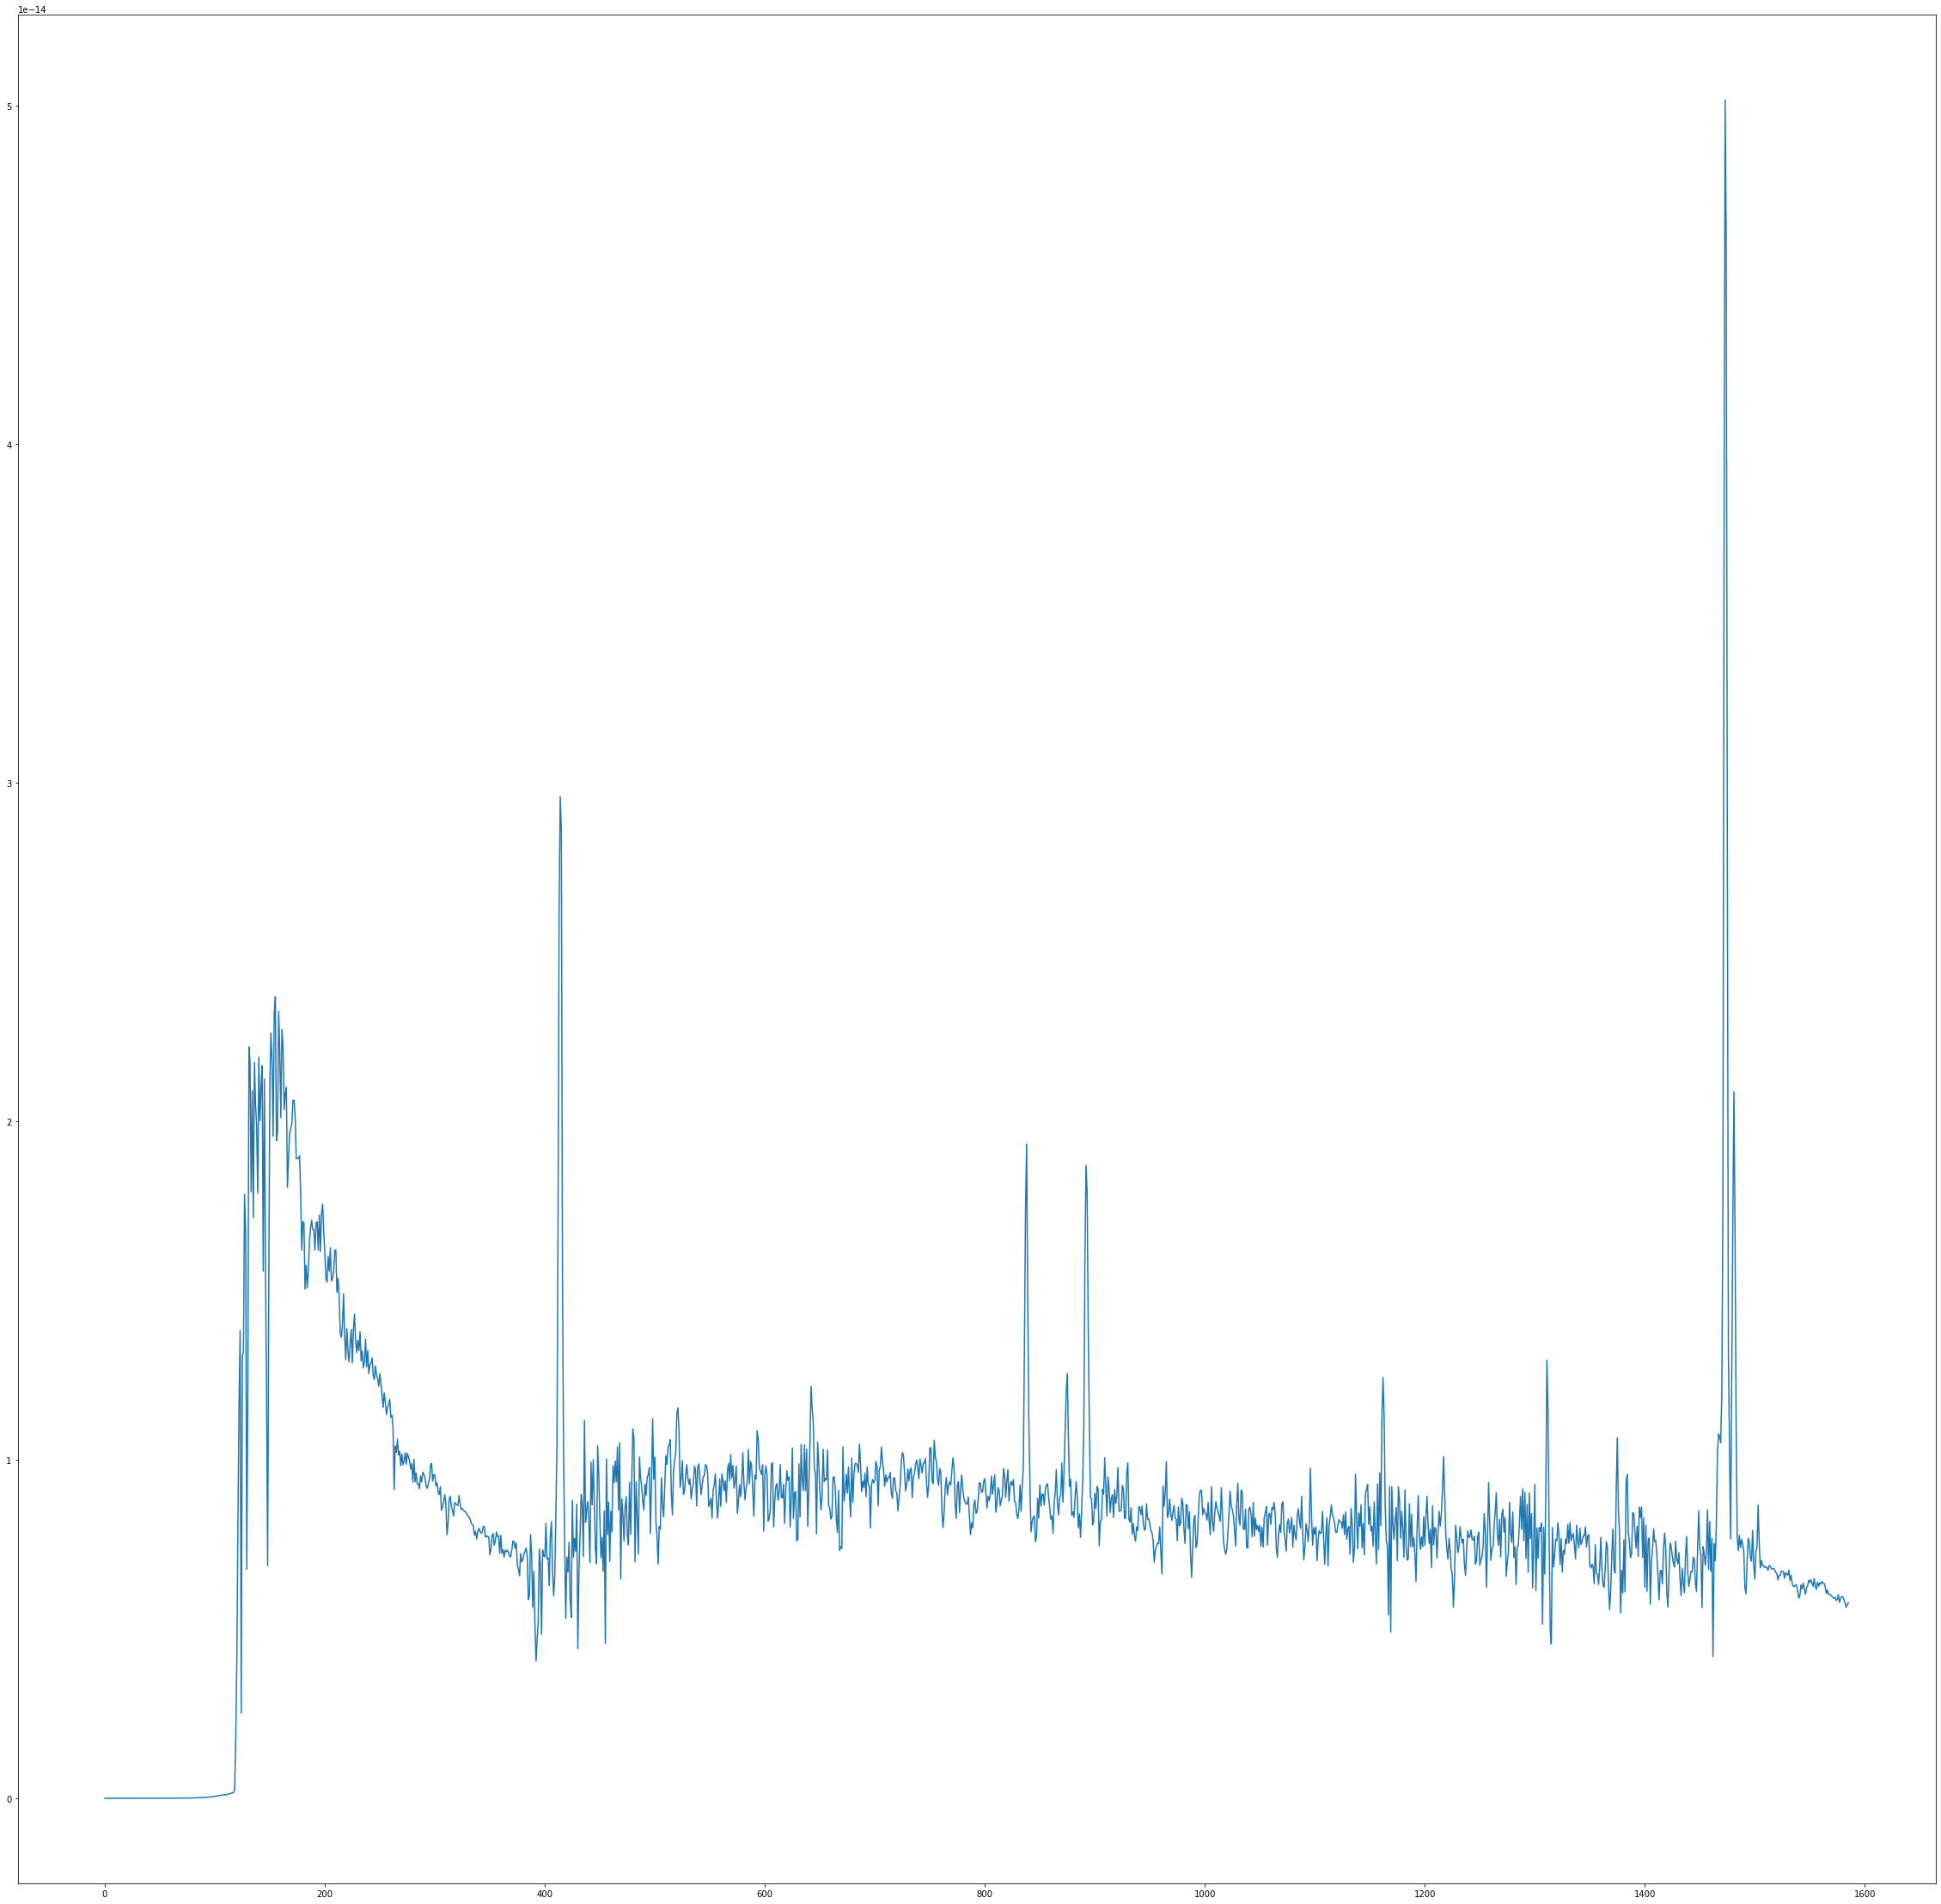

In [348]:
plt.plot(clean)

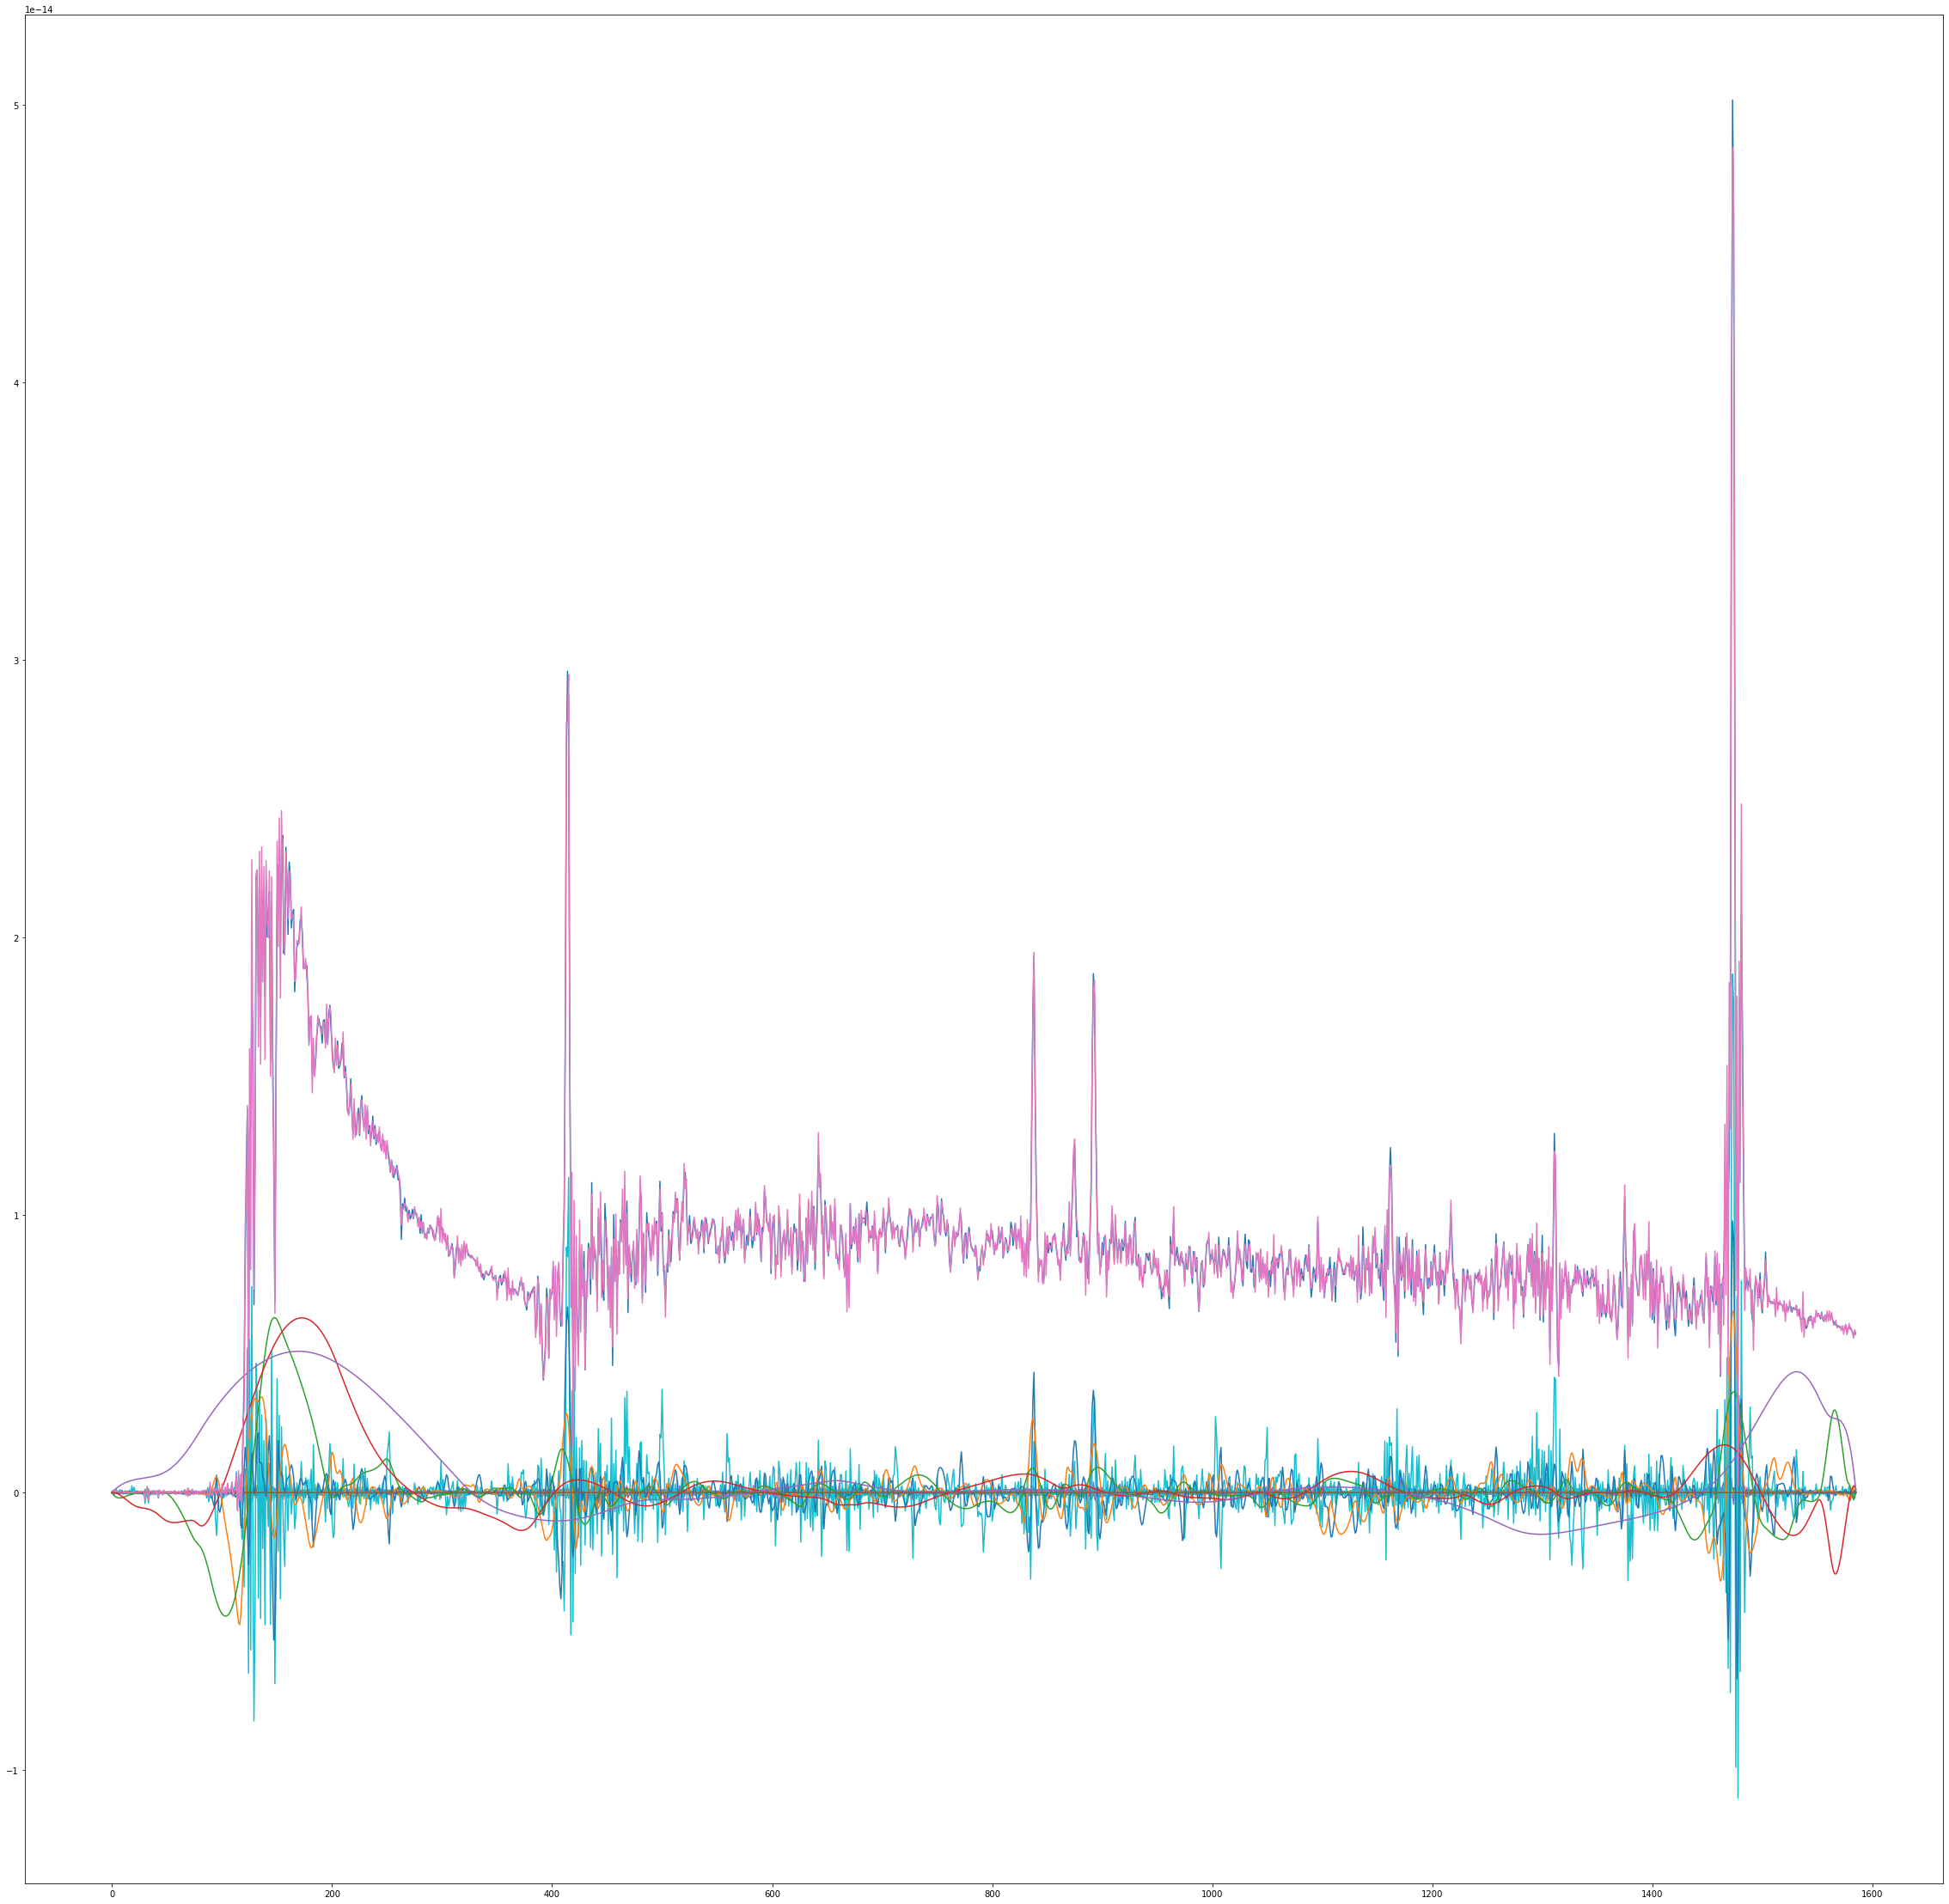

In [349]:
plt.rcParams["figure.figsize"] = (40,40)

plt.figure()

for each in range(decomposition.shape[0]):
        plt.plot(decomposition[each,:])
plt.show()

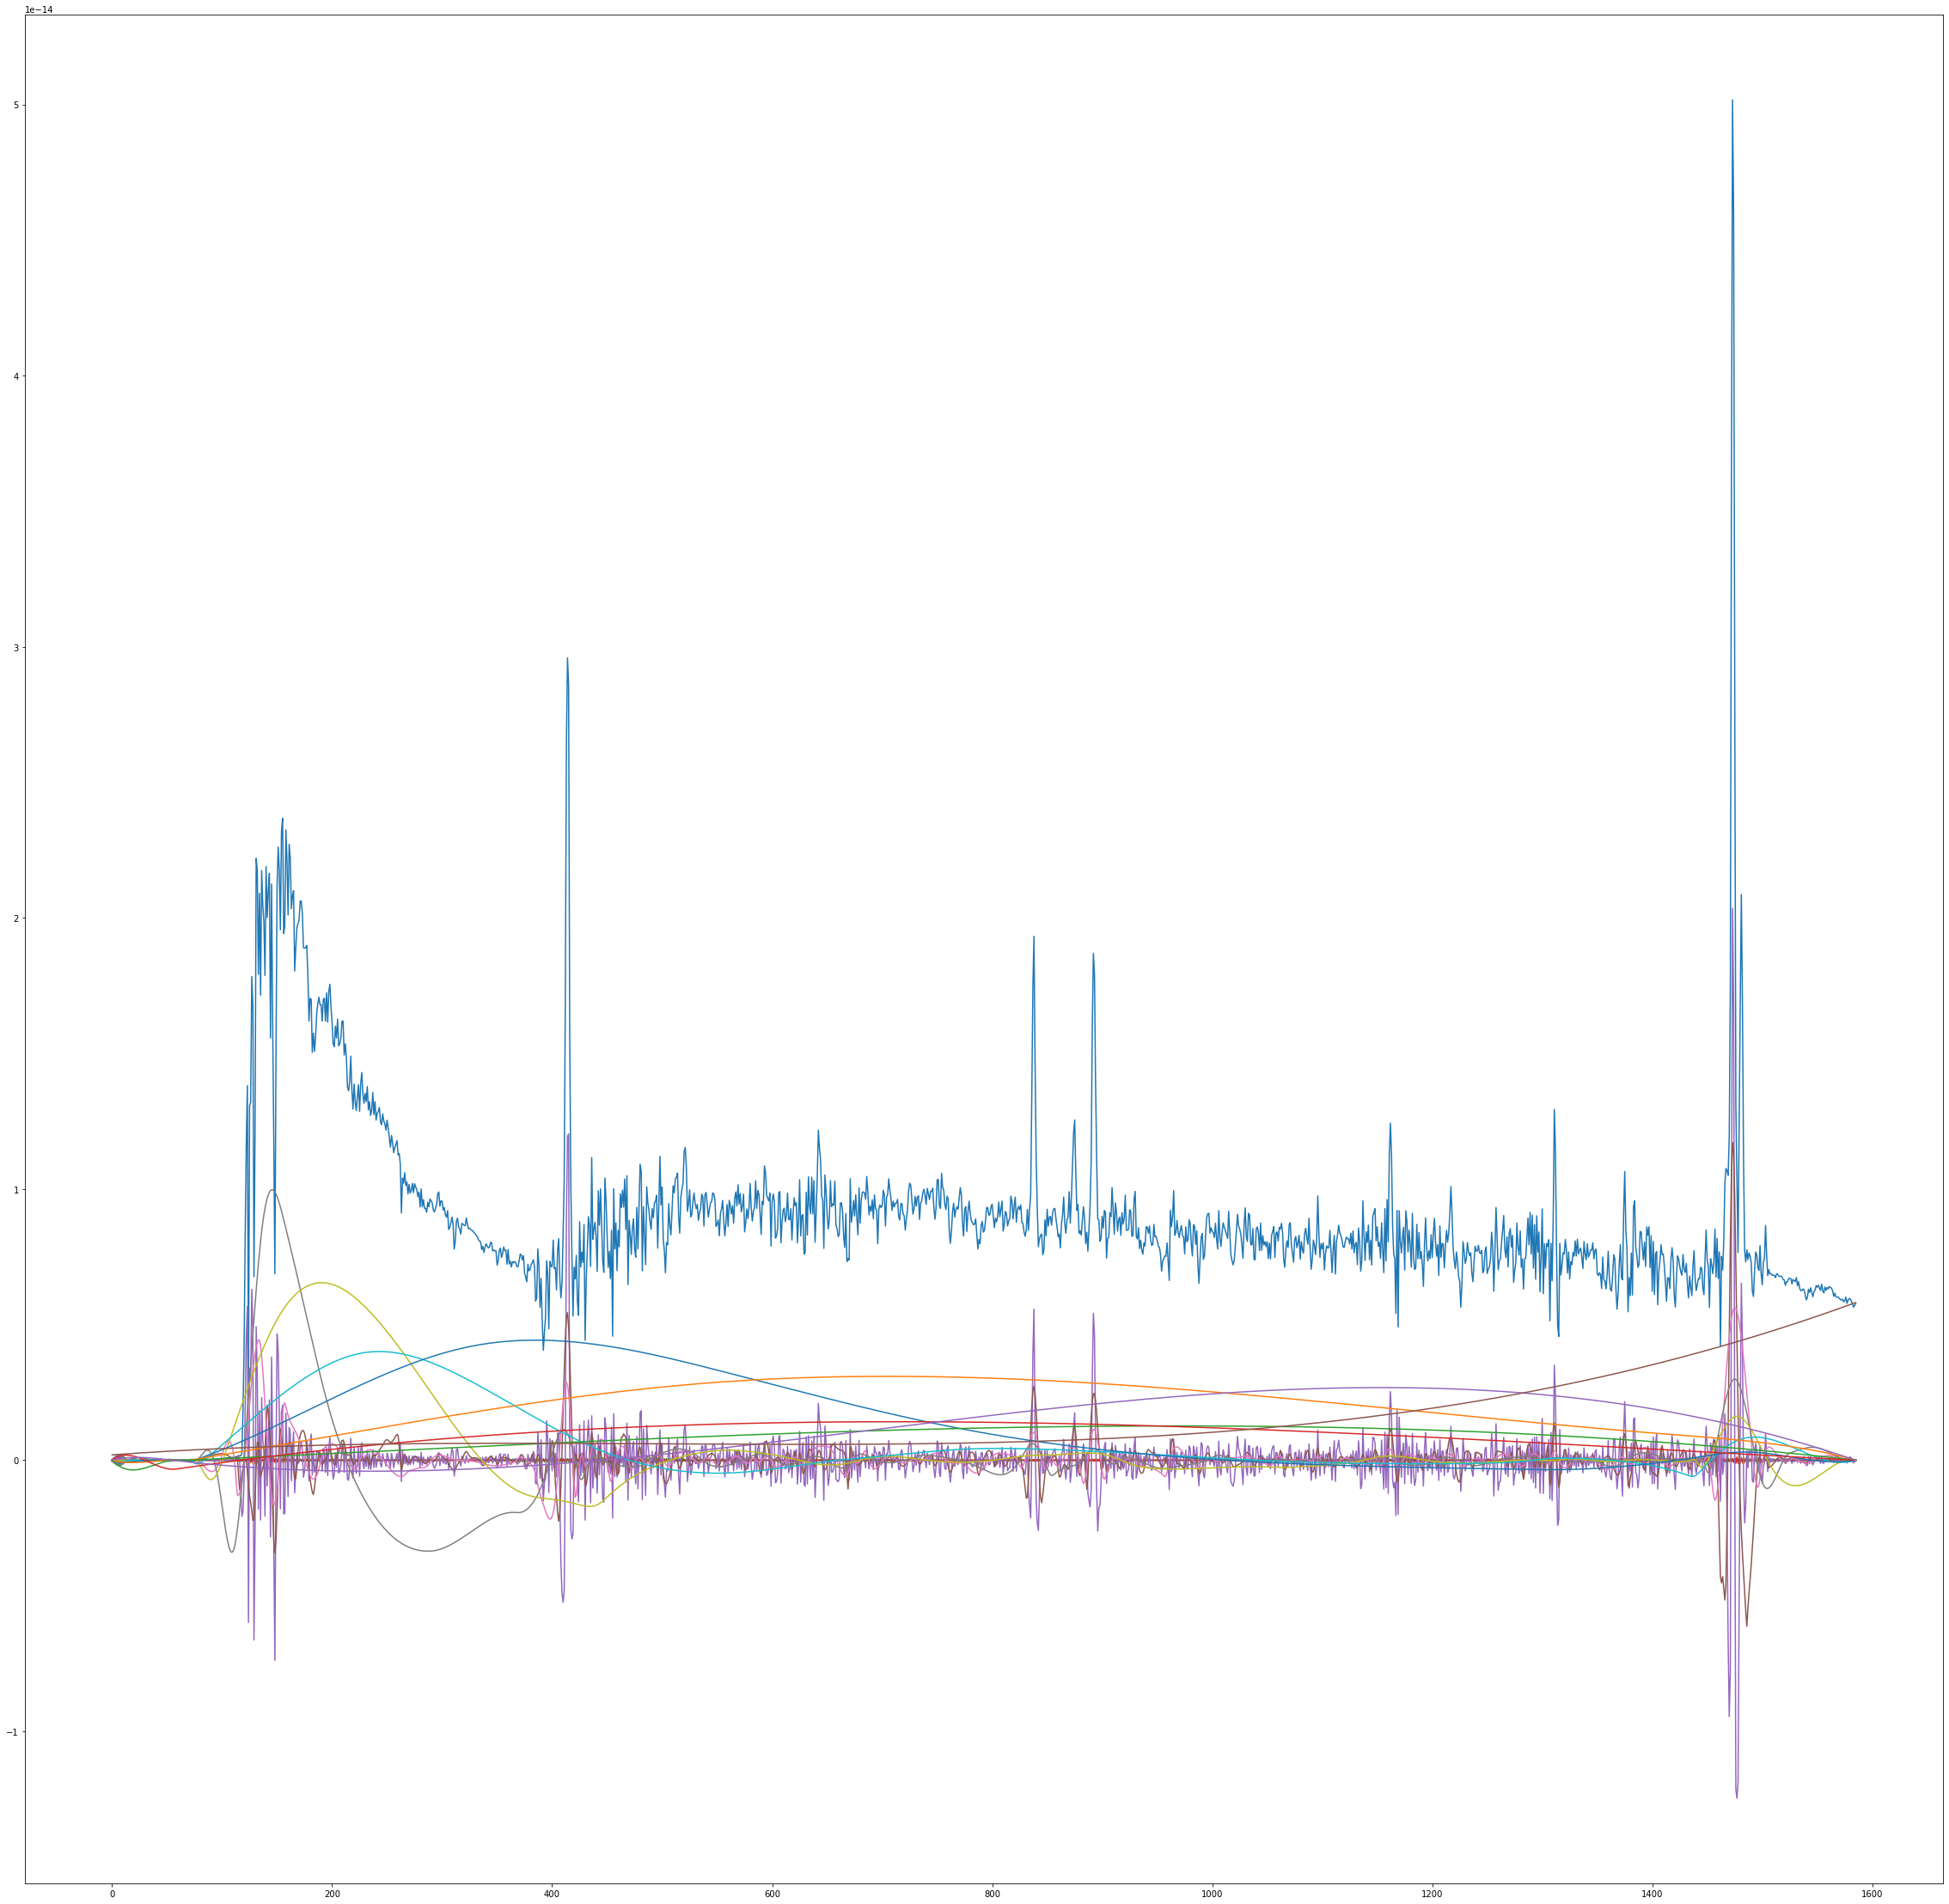


In [345]:
#seen above, first, is when t is 0.
#second one is when t is 1.

In [215]:
xr = [0,1,2,3,4,5,6]
print(xr[0:6])

[0, 1, 2, 3, 4, 5]
